# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

In [1]:
import os
import sys
import pickle
import numpy as np
import time
import string
import multiprocessing

from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

from Functions import TrainParameters
from Functions import DataHandler as dh
from Functions import FunctionsDataVisualization
from Functions.NoveltyDetectionAnalysis import NoveltyDetectionAnalysis
from Functions.StackedAutoEncoders import StackedAutoEncoders
from Functions.StatisticalAnalysis import KLDiv, EstPDF

num_processes = multiprocessing.cpu_count()

Using TensorFlow backend.


In [2]:
from SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis

analysis = SAENoveltyDetectionAnalysis(analysis_name="StackedAutoEncoder")

[+] Time to read data file: 1.09491205215 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [3]:
all_data, all_trgt, trgt_sparse = analysis.getData()

In [4]:
trn_params = analysis.getTrainParameters()

Reading from /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/10_folds_cross_validation.jbl

2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss


In [5]:
analysis.createSAEModels()
SAE, trn_data, trn_trgt, trn_trgt_sparse = analysis.getSAEModels()
CVO = analysis.CVO
n_folds = analysis.n_folds

[*] Initializing SAE Class for class A
[*] Initializing SAE Class for class B
[*] Initializing SAE Class for class C
[*] Initializing SAE Class for class D


In [7]:
import os
import sys
import pickle
import numpy as np
import time

from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K

import sklearn.metrics
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt

from Functions import TrainParameters as trnparams
from Functions import TrainFunctions
from Functions.StackedAutoEncoders import StackedAutoEncoders
from Functions import FunctionsDataVisualization
from Functions.StatisticalAnalysis import KLDiv, EstPDF

import multiprocessing

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'

# Enviroment variables
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

# paths to export results
base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/pictures_files'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# For multiprocessing purpose
num_processes = multiprocessing.cpu_count()

# Read data
m_time = time.time()

# Database caracteristics
database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

# Check if LofarData has created...
if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:],
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)

    all_data = balanced_data
    all_trgt = balanced_trgt

    class_labels_txt = ['A', 'B', 'C', 'D']
    
    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 1.59740447998e-05 seconds
Time to read data file: 1.08842802048 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


# Carregar parâmetros de treinamento

In [ ]:
# Load train parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
# if os.path.exists(trn_params_folder):
#     os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.SAENoveltyDetectionTrnParams(n_inits=1,
                                                       hidden_activation='tanh', # others tanh, relu, sigmoid, linear 
                                                       output_activation='linear',
                                                       n_epochs=300,
                                                       patience=30,
                                                       batch_size=256,
                                                       verbose=False,
                                                       optmizerAlgorithm='Adam',
                                                       metrics=['accuracy'], #mean_squared_error
                                                       loss='mean_squared_error') #kullback_leibler_divergence
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.SAENoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)
    
# Choose how many fold to be used in Cross Validation
n_folds = 10
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag, verbose=True)
print '\n'+trn_params.get_params_str()

# Inicialização de objetos da Classe SAE

In [ ]:
%time
SAE = {}
trn_data = {}
trn_trgt = {}
trn_trgt_sparse = {}
for inovelty in range(trgt_sparse.shape[1]):
    trn_data[inovelty] = all_data[all_trgt!=inovelty]
    trn_trgt[inovelty] = all_trgt[all_trgt!=inovelty]
    trn_trgt[inovelty][trn_trgt[inovelty]>inovelty] = trn_trgt[inovelty][trn_trgt[inovelty]>inovelty]-1
    trn_trgt_sparse[inovelty] = np_utils.to_categorical(trn_trgt[inovelty].astype(int))
    # Initialize an SAE object for all novelties
    SAE[inovelty] = StackedAutoEncoders(params           = trn_params,
                                        development_flag = development_flag,
                                        n_folds          = n_folds,
                                        save_path        = results_path,
                                        CVO              = CVO,
                                        noveltyDetection = True,
                                        inovelty         = inovelty)

In [ ]:
range(trgt_sparse.shape[1])

# Treinamento do Stacked Auto Encoder

In [ ]:
##### Train Process #####
inovelty = 1
novelty_train = [inovelty]
print 'Novelty to Train: %i'%inovelty

# Choose layer to be trained
layer = 1

n_folds = len(CVO[inovelty])

hidden_neurons = range(400,0,-50) + [2]
# hidden_neurons = [20]

print "Neurons Topology: ", hidden_neurons
print "Layer: %i"%layer
print "N. of Folds: %i"%n_folds

regularizer = ""
regularizer_param = 0.5
if len(regularizer) != 0:    
    print "Regularizer: %s"%regularizer
    print "Parameter Value: %i"%regularizer_param

# Functions defined to be used by multiprocessing.Pool()
def trainNeuron(ineuron):
    for ifold in range(n_folds):
        SAE[inovelty].trainLayer(data = trn_data[inovelty],
                                 trgt = trn_trgt[inovelty],
                                 ifold = ifold,
                                 hidden_neurons = hidden_neurons + [ineuron],
                                 layer = layer,
                                 regularizer = regularizer,
                                 regularizer_param = regularizer_param)

def trainFold(ifold):
    return  SAE[inovelty].trainLayer(data = trn_data[inovelty],
                                     trgt = trn_trgt[inovelty],
                                     ifold = ifold,
                                     hidden_neurons = hidden_neurons,
                                     layer = layer,
                                     regularizer = regularizer,
                                     regularizer_param = regularizer_param)

start_time = time.time()

if K.backend() == 'theano':
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    ####################### SAE LAYERS ############################
    # It is necessary to choose the layer to be trained

    # To train on multiple cores sweeping the number of folds
    folds = range(len(CVO[inovelty]))
    results = p.map(trainFold, folds)

    # To train multiple topologies sweeping the number of neurons
    # neurons_mat = range(0,400,50) (start,final,step)
    # results = p.map(trainNeuron, neurons_mat)

    p.close()
    p.join()
else: 
    for ifold in range(len(CVO[inovelty])):
        result = trainFold(ifold)

end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

In [ ]:
# hidden_neurons = range(400,0,-50)
hidden_neurons = [1]
inovelty = 0
regularizer = ""
regularizer_param = 0.5
SAE[inovelty].train(fineTuning = True,
                    trainingType="foldSweep",
                    data = trn_data[inovelty],
                    trgt = trn_trgt[inovelty],
                    ifold = 0,
                    hidden_neurons = hidden_neurons,
                    neurons_mat = range(1,11),
                    layer = 1,
                    regularizer = regularizer,
                    regularizer_param = regularizer_param)

# Estimação de PDF

In [ ]:
%time
# Reconstruction Analysis
%matplotlib inline 

# generate analysis data
save_path=results_path

current_analysis = 'pdf_estimation'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 0
regularizer = ""
regularizer_param = 0.5

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

models = {}
know_outputs = {}
novelty_outputs = {}

reconstructed_data = {}
klDivergenceFreq = {}

n_bins = 100

def getPDF(ifold):
    print '[*] Processing %i fold...'%ifold
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        
    known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    models[ifold] = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer],
                                           layer=layer, ifold=ifold)
    
    know_outputs[ifold] = models[ifold].predict(known_data)
    novelty_outputs[ifold] = models[ifold].predict(novelty_data)
    
    pdf_freq = np.zeros([all_data.shape[1]], dtype=object)
    for ifrequency in range(0,400):
        data = known_data[:,ifrequency]
        reconstructed_data = know_outputs[ifold][:,ifrequency]
        m_bins = np.linspace(data.min(), data.max(), n_bins)
        
        pdf_freq[ifrequency] = EstPDF(data.reshape(-1,1),
                               bins=m_bins, mode='kernel', kernel='epanechnikov',
                               kernel_bw=0.1, verbose=False)
    return ifold, pdf_freq

# Start Parallel processing
p = multiprocessing.Pool(processes=num_processes)

folds = range(len(CVO[inovelty]))
pdfEstimated = p.map(getPDF, folds)

p.close()
p.join()

# Estimação de PDF através de Espectro

In [ ]:
ifrequency = 399
for ifold in range(n_folds):
    fig, m_ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)
    m_ax.plot(pdfEstimated[ifold][1][ifrequency][1], pdfEstimated[ifold][1][ifrequency][0])
    m_ax.set_title('PDF x Frequency(%i) - Layer %i - Fold %i - Novelty Class %i'%(ifrequency,layer, ifold, inovelty), fontweight='bold', fontsize=16)
    m_ax.set_xlabel('Amplitude', fontsize=18)
    m_ax.set_ylabel('Estimated Probability Density', fontsize=18)

In [ ]:
inovelty = 0
layer = 1
ifold = 0

iwindow = 3

freqs = range(0,400)

known_outputs = {}
novelty_outputs = {}

print '[*] Processing %i fold...'%ifold
train_id, test_id = CVO[inovelty][ifold]

# normalize known classes
if trn_params.params['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
elif trn_params.params['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
elif trn_params.params['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
novelty_data = scaler.transform(all_data[all_trgt==inovelty])

models[ifold] = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                       hidden_neurons=hidden_neurons[:layer],
                                       layer=layer, ifold=ifold)

known_outputs[ifold] = models[ifold].predict(known_data)
novelty_outputs[ifold] = models[ifold].predict(novelty_data)

pdfEstimated = known_data[iwindow]/metrics.auc(freqs, known_data[iwindow])
pdfEstimated_output = known_outputs[ifold][iwindow]/metrics.auc(freqs, known_outputs[ifold][iwindow])

def KLDiv(p_pdf, q_pdf):
    kl_values = []
    for i in range(len(p_pdf)):
        if p_pdf[i] == 0 or q_pdf[i] == 0 :
            kl_values = np.append(kl_values,0)
        else:
            kl_value = np.abs(p_pdf[i]*np.log10(p_pdf[i]/q_pdf[i]))
            if np.isnan(kl_value):
                kl_values = np.append(kl_values,0)
            else:
                kl_values = np.append(kl_values,kl_value)
    return [np.sum(kl_values),kl_values]

kl_novelty = np.zeros(novelty_data.shape[1])
for iwindow in range(novelty_data.shape[1]):
    pdfEstimated_novelty = novelty_data[iwindow]/metrics.auc(freqs, novelty_data[iwindow])
    pdfEstimated_noveltyoutput = novelty_outputs[ifold][iwindow]/metrics.auc(freqs, novelty_outputs[ifold][iwindow])
    [kl_novelty[iwindow], klVector] = KLDiv(pdfEstimated_novelty, pdfEstimated_noveltyoutput)
    
plt.figure(figsize=[8,8])

m_bins = np.linspace(-0, 20, 50)
kl_novelty.shape
n, bins, patches = plt.hist(kl_novelty, bins=m_bins, alpha=0.8, normed=1)
plt.ylabel('Frequency', fontweight='bold',fontsize=15)
plt.title('Histogram of KL Divergence of Novelty Class', fontweight='bold',fontsize=15)


In [ ]:
def KLDiv(p_pdf, q_pdf):
    kl_values = []
    for i in range(len(p_pdf)):
        if p_pdf[i] == 0 or q_pdf[i] == 0 :
            kl_values = np.append(kl_values,0)
        else:
            kl_value = np.abs(p_pdf[i]*np.log10(p_pdf[i]/q_pdf[i]))
            if np.isnan(kl_value):
                kl_values = np.append(kl_values,0)
            else:
                kl_values = np.append(kl_values,kl_value)
    return [np.sum(kl_values),kl_values]

In [ ]:
# Histogram of KL Divergence

# Choose layer 
layer = 4

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 1
regularizer = ""
regularizer_param = 0.5

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

for ifold in range(len(CVO[inovelty])):
    class_outputs = {}
    class_data = {}
    kl_class = {}

    freqs = range(0,400)

    irow = -1
    icolumn = 0

    rows = 2
    columns = 2
    fig, m_ax = plt.subplots(figsize=(12,12),nrows=rows, ncols=columns)

    m_bins = np.linspace(-0, 20, 50)
    itarget = 0
    ilabel = 0

    labels = range(trgt_sparse.shape[1])
    labels.remove(inovelty)

    print "Layer: %i"%layer
    print "Novelty Class: %i"%inovelty
    print "Neurons Topology: %s"%neurons_str
    print "Fold: %i"%ifold
    for iclass in range(len(class_labels)):
        class_data[iclass] = np.zeros(n_folds, dtype=object)
        class_outputs[iclass] = np.zeros(n_folds, dtype=object)

        print '[*] Processing class %i...'%(iclass)
        train_id, test_id = CVO[inovelty][ifold]

        # normalize known classes
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

        if iclass == inovelty:
            class_data[iclass][ifold] = scaler.transform(all_data[all_trgt==inovelty])
        else:
            tmp = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
            class_data[iclass][ifold] = tmp[all_trgt[test_id]==itarget]
            itarget = itarget + 1

        model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                               hidden_neurons=hidden_neurons[:layer],
                                               layer=layer, ifold=ifold)

        class_outputs[iclass][ifold] = model.predict(class_data[iclass][ifold])
        kl_class[iclass] = np.zeros(class_data[iclass][ifold].shape[1])

        pdfEstimated = []
        pdfEstimated_output = []
        for iwindow in range(class_data[iclass][ifold].shape[1]):
            pdfEstimated = class_data[iclass][ifold][iwindow]/metrics.auc(freqs, class_data[iclass][ifold][iwindow])
            pdfEstimated_output = class_outputs[iclass][ifold][iwindow]/metrics.auc(freqs, class_outputs[iclass][ifold][iwindow])
            [kl_class[iclass][iwindow], klVector] = KLDiv(pdfEstimated, pdfEstimated_output)
        if iclass % columns == 0:
            irow = irow + 1
            icolumn = 0
        else: 
            icolumn = icolumn + 1

        m_ax[irow, icolumn].set_ylabel('Frequency', fontweight='bold',fontsize=15)
        if iclass == inovelty:
            color = 'red'
        else:
            color = 'blue'
        n, bins, patches = m_ax[irow,icolumn].hist(kl_class[iclass], bins=m_bins, alpha=0.8, normed=1, color=color)
        m_ax[irow,icolumn].set_title('KL Divergence of Class %i'%(iclass), fontweight='bold',fontsize=15)
        m_ax[irow,icolumn].grid()
    plt.show()

# Histograma dos Máximos de KL

In [ ]:
# Histogram of Max KL Divergence

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 0
regularizer = ""
regularizer_param = 0.5

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

for ifold in range(len(CVO[inovelty])):
    class_outputs = {}
    class_data = {}
    kl_class = {}

    freqs = range(0,400)

    irow = -1
    icolumn = 0

    rows = 2
    columns = 2
    fig, m_ax = plt.subplots(figsize=(12,12),nrows=rows, ncols=columns)

    m_bins = np.linspace(-0, 20, 50)
    itarget = 0

    labels = range(trgt_sparse.shape[1])
    labels.remove(inovelty)

    print "Layer: %i"%layer
    print "Novelty Class: %i"%inovelty
    print "Neurons Topology: %s"%neurons_str
    print "Fold: %i"%ifold
    for iclass in range(len(class_labels)):
        class_data[iclass] = np.zeros(n_folds, dtype=object)
        class_outputs[iclass] = np.zeros(n_folds, dtype=object)

        print '[*] Processing class %i...'%(iclass)
        train_id, test_id = CVO[inovelty][ifold]

        # normalize known classes
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

        if iclass == inovelty:
            class_data[iclass][ifold] = scaler.transform(all_data[all_trgt==inovelty])
        else:
            tmp = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
            class_data[iclass][ifold] = tmp[all_trgt[test_id]==itarget]
            itarget = itarget + 1

        model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                               hidden_neurons=hidden_neurons[:layer],
                                               layer=layer, ifold=ifold)

        class_outputs[iclass][ifold] = model.predict(class_data[iclass][ifold])
        kl_class[iclass] = np.zeros(class_data[iclass][ifold].shape[0])

        pdfEstimated = []
        pdfEstimated_output = []
        for iwindow in range(class_data[iclass][ifold].shape[0]):
            pdfEstimated = class_data[iclass][ifold][iwindow,:]/metrics.auc(freqs, class_data[iclass][ifold][iwindow,:])
            pdfEstimated_output = class_outputs[iclass][ifold][iwindow,:]/metrics.auc(freqs, class_outputs[iclass][ifold][iwindow,:])
            [kl_class[iclass][iwindow], klVector] = KLDiv(pdfEstimated, pdfEstimated_output)
        if iclass % columns == 0:
            irow = irow + 1
            icolumn = 0
        else: 
            icolumn = icolumn + 1

        m_ax[irow, icolumn].set_ylabel('Frequency', fontweight='bold',fontsize=15)
        if iclass == inovelty:
            color = 'red'
        else:
            color = 'blue'
        n, bins, patches = m_ax[irow,icolumn].hist(np.max(kl_class[iclass], axis=1), bins=m_bins, alpha=0.8, normed=1, color=color)
        m_ax[irow,icolumn].set_title('Maximum KL Divergence of Class %i'%(iclass), fontweight='bold',fontsize=15)
        m_ax[irow,icolumn].grid()
    plt.show()         

In [ ]:
pdfEstimated.shape

# Divergência KL - LOFARGRAMA

In [ ]:
# LOFARGram for reconstructed input 
current_analysis = 'LOFARGram_reconstruction_first_layer'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose neurons topology
ineuron = 400

# Choose model
inovelty = 1

# Choose num of lines to plot
points = 100

params_str = trn_params.get_params_str()
    
for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])

    norm_data = scaler.transform(all_data)

    # Get the model file
    model_str = '%s/%s/%s_%i_novelty_%i_folds_%s_400x%i_neurons'%(results_path,analysis_str,
                                                               model_prefix_str,inovelty,
                                                               n_folds,params_str,
                                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    print 'Loading %s'%file_name
    model = load_model(file_name)
    
    all_output = model.predict(norm_data[all_trgt==inovelty])

    m_fontsize = 12

    fig, subplot_array = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        if i == 0:
            plt.imshow(norm_data[all_trgt==inovelty,:],
               cmap="jet",extent=[1, 400, norm_data[all_trgt==inovelty,:].shape[0],1],
               aspect="auto")
            plt.xlabel('Frequencies (Hz)', fontsize= m_fontsize, fontweight="bold")
            plt.title('Lofar Analysis for Original Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
        if (i == 1):
            plt.ylabel('Time (seconds)', fontsize= m_fontsize, fontweight="bold")
            plt.imshow(all_output,
               cmap="jet",extent=[1, 400, all_output.shape[0],1],
               aspect="auto")
            plt.title('Lofar Analysis for Reconstructed Data of %s'%(class_labels[inovelty]), fontsize= m_fontsize, fontweight="bold")
        
        # Plot lines at frequencies with high errors
        for index in indexes[:points]:
            plt.axvline(index, color='r', alpha=0.7)
            
        plt.xticks(np.linspace(0,400,9),rotation=45)
        cbar = plt.colorbar()
        plt.clim(-2,9)
        #if ((iclass == 1) or (iclass==3)):
        cbar.ax.set_ylabel('dB',fontweight='bold') 
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_inovelty'%inovelty+'_%i'%ifold+'_fold'+'_%s'%neurons_str+'_neurons_'+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)

# Divergência KL - Frequência

In [ ]:
%time
# Reconstruction Analysis
%matplotlib inline 

# generate analysis data
save_path=results_path

current_analysis = 'kl_divergence_frequency'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 0
regularizer = ""
regularizer_param = 0.5

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

models = {}
know_outputs = {}
novelty_outputs = {}

reconstructed_data = {}
klDivergenceFreq = {}

n_bins = 100

def getKlDiv(ifold):
    print '[*] Processing %i fold...'%ifold
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        
    known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    models[ifold] = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer],
                                           layer=layer, ifold=ifold)
    
    know_outputs[ifold] = models[ifold].predict(known_data)
    novelty_outputs[ifold] = models[ifold].predict(novelty_data)
    
    kl = np.zeros([all_data.shape[1]], dtype=object)
    for ifrequency in range(0,400):
        data = known_data[:,ifrequency]
        reconstructed_data = know_outputs[ifold][:,ifrequency]
        m_bins = np.linspace(data.min(), data.max(), n_bins)
        kl[ifrequency] = KLDiv(data.reshape(-1,1), reconstructed_data.reshape(-1,1),
                               bins=m_bins, mode='kernel', kernel='epanechnikov',
                               kernel_bw=0.1, verbose=False)
        kl[ifrequency] = kl[ifrequency][0]
    return ifold, kl

# Start Parallel processing
p = multiprocessing.Pool(processes=num_processes)

folds = range(len(CVO[inovelty]))
klDivergenceFreq = p.map(getKlDiv, folds)

p.close()
p.join()

freqs = range(0,400)
for ifold in range(n_folds):
    fig, m_ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)
    m_ax.plot(freqs, klDivergenceFreq[ifold][1])
    m_ax.set_title('KL Divergence x Frequency - Layer %i - Fold %i - Novelty Class %i'%(layer, ifold, inovelty), fontweight='bold', fontsize=16)
    m_ax.set_xlabel('Frequency', fontsize=18)
    m_ax.set_ylabel('Kullback-Leibler Divergence', fontsize=18)

# Divergência KL Naive - Supondo independência nas features

In [ ]:
%time
# Reconstruction Analysis
%matplotlib inline 

# generate analysis data
save_path=results_path

current_analysis = 'klDivergence_naive'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 0
regularizer = ""
regularizer_param = 0.5

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

reconstructed_data = {}
klDivergenceFreq = {}

n_bins = 100

def KLDivCustom(p_pdf, q_pdf):   
    kl_values = []
    for i in range(len(p_pdf)):
        if p_pdf[i] == 0 or q_pdf[i] == 0 :
            kl_values = np.append(kl_values,0)
        else:
            kl_value = np.abs(p_pdf[i]*np.log10(p_pdf[i]/q_pdf[i]))
            if np.isnan(kl_value):
                kl_values = np.append(kl_values,0)
            else:
                kl_values = np.append(kl_values,kl_value)
    return [np.sum(kl_values),kl_values]

def getKL(ifold):
    print '[*] Processing %i fold...'%ifold
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        
    known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer],
                                           layer=layer, ifold=ifold)
    
    known_output = model.predict(known_data)
    novelty_output = model.predict(novelty_data)
    
    pdf_known = np.zeros([all_data.shape[1]], dtype=object)
    pdf_known_output = np.zeros([all_data.shape[1]], dtype=object)
    
    pdf_novelty = np.zeros([all_data.shape[1]], dtype=object)
    pdf_novelty_output = np.zeros([all_data.shape[1]], dtype=object)

    joint_pdf_known = np.zeros([all_data.shape[1]], dtype=object)
    joint_pdf_known_output = np.zeros([all_data.shape[1]], dtype=object)
    
    joint_pdf_novelty = np.zeros([all_data.shape[1]], dtype=object)
    joint_pdf_novelty_output = np.zeros([all_data.shape[1]], dtype=object)
    # Suppose independence in frequency, so the joint probability function becomes the product of marginal PDFs
    for ifrequency in range(0,400):
        # Estimate PDF for known data reconstruction
        data = known_data[:,ifrequency]
        reconstructed_data = known_output[:,ifrequency]
        m_bins = np.linspace(data.min(), data.max(), n_bins)
        
        [p_pdf,p_bins] = EstPDF(data.reshape(-1,1),
                                bins=m_bins, mode='kernel', kernel='epanechnikov',
                                kernel_bw=0.1, verbose=False)
        pdf_known[ifrequency]  = p_pdf
        
        [p_pdf,p_bins] = EstPDF(reconstructed_data.reshape(-1,1),
                                bins=m_bins, mode='kernel', kernel='epanechnikov',
                                kernel_bw=0.1, verbose=False)
        pdf_known_output[ifrequency]  = p_pdf
        
        # Estimate PDF for novelty data reconstruction
        data = novelty_data[:,ifrequency]
        reconstructed_novelty_data = novelty_output[:,ifrequency]
        m_bins = np.linspace(data.min(), data.max(), n_bins)
        
        [p_pdf,p_bins] = EstPDF(data.reshape(-1,1),
                                 bins=m_bins, mode='hist', kernel='epanechnikov',
                                 kernel_bw=0.1, verbose=False)
        pdf_novelty[ifrequency] = p_pdf
        
        [p_pdf,p_bins] = EstPDF(reconstructed_novelty_data.reshape(-1,1),
                                bins=m_bins, mode='hist', kernel='epanechnikov',
                                kernel_bw=0.1, verbose=False)
        pdf_novelty_output[ifrequency] = p_pdf

        if ifrequency == 0:
            joint_pdf_known = pdf_known[ifrequency]
            joint_pdf_known_output = pdf_known_output[ifrequency]
            joint_pdf_novelty = pdf_novelty[ifrequency]
            joint_pdf_novelty_output = pdf_novelty_output[ifrequency]
        else:
            joint_pdf_known = joint_pdf_known * pdf_known[ifrequency]
            joint_pdf_known_output = joint_pdf_known_output * pdf_known_output[ifrequency]
            joint_pdf_novelty = joint_pdf_novelty * pdf_novelty[ifrequency]
            joint_pdf_novelty_output = joint_pdf_novelty_output * pdf_novelty_output[ifrequency]
#     # Calculate KL Div for known data reconstruction
#     klKnown = KLDivCustom(joint_pdf_known, joint_pdf_known_output)
#     klKnown = klKnown[0] 
    
#     # Calculate KL Div for novelty data reconstruction
#     klNovelty = KLDivCustom(joint_pdf_known, joint_pdf_known_output)
#     klNovelty = klNovelty[0]         
        
    return ifold #, klKnown, klNovelty

# Start Parallel processing
p = multiprocessing.Pool(processes=num_processes+2)

folds = range(len(CVO[inovelty]))
klDivergence = p.map(getKL, folds)

p.close()
p.join()

In [ ]:
ifold = 0
print '[*] Processing %i fold...'%ifold
train_id, test_id = CVO[inovelty][ifold]

# normalize known classes
if trn_params.params['norm'] == 'mapstd':
    scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
elif trn_params.params['norm'] == 'mapstd_rob':
    scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
elif trn_params.params['norm'] == 'mapminmax':
    scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
novelty_data = scaler.transform(all_data[all_trgt==inovelty])

model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                       hidden_neurons=hidden_neurons[:layer],
                                       layer=layer, ifold=ifold)

known_output = model.predict(known_data)
novelty_output = model.predict(novelty_data)

pdf_known = np.zeros([all_data.shape[1]], dtype=object)
pdf_known_output = np.zeros([all_data.shape[1]], dtype=object)

pdf_novelty = np.zeros([all_data.shape[1]], dtype=object)
pdf_novelty_output = np.zeros([all_data.shape[1]], dtype=object)

# Suppose independence in frequency, so the joint probability function becomes the product of marginal PDFs
for ifrequency in range(0,400):
    # Estimate PDF for known data reconstruction
    data = known_data[:,ifrequency]
    reconstructed_data = known_output[:,ifrequency]
    m_bins = np.linspace(data.min(), data.max(), n_bins)

    [p_pdf,p_bins] = EstPDF(data.reshape(-1,1),
                            bins=m_bins, mode='hist', kernel='epanechnikov',
                            kernel_bw=0.1, verbose=False)
    pdf_known[ifrequency]  = p_pdf

    [p_pdf,p_bins] = EstPDF(reconstructed_data.reshape(-1,1),
                            bins=m_bins, mode='hist', kernel='epanechnikov',
                            kernel_bw=0.1, verbose=False)
    pdf_known_output[ifrequency]  = p_pdf

    # Estimate PDF for novelty data reconstruction
    data = novelty_data[:,ifrequency]
    reconstructed_novelty_data = novelty_output[:,ifrequency]
    m_bins = np.linspace(data.min(), data.max(), n_bins)

    [p_pdf,p_bins] = EstPDF(data.reshape(-1,1),
                            bins=m_bins, mode='kernel', kernel='epanechnikov',
                            kernel_bw=0.1, verbose=False)
    pdf_novelty[ifrequency] = p_pdf

    [p_pdf,p_bins] = EstPDF(reconstructed_novelty_data.reshape(-1,1),
                            bins=m_bins, mode='kernel', kernel='epanechnikov',
                            kernel_bw=0.1, verbose=False)
    pdf_novelty_output[ifrequency] = p_pdf
for ifrequency in range(0,400):
    if ifrequency == 0:
        joint_pdf_known = pdf_known[ifrequency]
        joint_pdf_known_output = pdf_known_output[ifrequency]
        joint_pdf_novelty = pdf_novelty[ifrequency]
        joint_pdf_novelty_output = pdf_novelty_output[ifrequency]
    else:
        joint_pdf_known = joint_pdf_known * pdf_known[ifrequency]
        joint_pdf_known_output = joint_pdf_known_output * pdf_known_output[ifrequency]
        joint_pdf_novelty = joint_pdf_novelty * pdf_novelty[ifrequency]
        joint_pdf_novelty_output = joint_pdf_novelty_output * pdf_novelty_output[ifrequency]

In [ ]:
ifrequency = 0
fig, m_ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)
m_ax.plot(p_bins, p_pdf*(pdf_known[ifrequency])
m_ax.set_title('PDF x Frequency(%i) - Layer %i - Fold %i - Novelty Class %i'%(ifrequency,layer, ifold, inovelty), fontweight='bold', fontsize=16)
m_ax.set_xlabel('Amplitude', fontsize=18)
m_ax.set_ylabel('Estimated Probability Density', fontsize=18)

In [ ]:
joint_pdf_known = np.ones([n_bins])
joint_pdf_known_output = np.ones([n_bins])
joint_pdf_novelty = np.ones([n_bins])
joint_pdf_novelty_output = np.ones([n_bins])

for ifrequency in range(0,10):
    joint_pdf_known = joint_pdf_known*pdf_known[ifrequency]
    joint_pdf_known_output = joint_pdf_known_output * pdf_known_output[ifrequency]
    joint_pdf_novelty = joint_pdf_novelty * pdf_novelty[ifrequency]
    joint_pdf_novelty_output = joint_pdf_novelty_output * pdf_novelty_output[ifrequency]
print joint_pdf_known
print joint_pdf_known_output

In [ ]:
pdf_known[ifrequency]*

In [ ]:
pdf_known

# Divergência KL - Variação de Neurônios

In [11]:
# Neuron variation x KL Divergence
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [1] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
inovelty = 0
regularizer = ""
regularizer_param = 0.5

# generate analysis data
save_path=results_path

current_analysis = 'klDivergence_%i_layer_%i_novelty'%(layer, inovelty)
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
if regularizer != None or len(regularizer) != 0:
    analysis_file_name='%s/%s/%s_%s_regularizer(%f)_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,regularizer,
                                                                                 regularizer_param,current_analysis)
else:
    analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

n_folds = len(CVO[inovelty])

klDivergenceFreq = {}
klDivergenceKnown = np.zeros([n_folds, len(neurons_mat)], dtype=object)
klDivergenceKnownFreq = {}
klDivergenceNovelty = np.zeros([n_folds, len(neurons_mat)], dtype=object)
klDivergenceNoveltyFreq = {}

# if os.path.exists(analysis_file_name):
#     os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    for ineuron in neurons_mat: 
        if ineuron == 0:
            ineuron = 1
        neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer-1]+[ineuron])

        models = {}
        outputs = {}
        norm_data = {}
        reconstructed_known_data = {}
        reconstructed_novelty_data = {}
        if verbose: 
            print '[*] Layer: %i - Topology: %s'%(layer, neurons_str)

        n_bins = 100

        def getKlDiv(ifold):
            train_id, test_id = CVO[inovelty][ifold]

            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                           layer=layer, ifold=ifold, regularizer=regularizer, regularizer_param=regularizer_param)

            known_output = model.predict(known_data)
            novelty_output = model.predict(novelty_data)

            klKnown = np.zeros([all_data.shape[1]], dtype=object)
            klNovelty = np.zeros([all_data.shape[1]], dtype=object)
            
            for ifrequency in range(0,400):
                # Calculate KL Div for known data reconstruction
                known_data_freq = known_data[:,ifrequency]
                reconstructed_known_data = known_output[:,ifrequency]

                m_bins = np.linspace(known_data_freq.min(), known_data_freq.max(), n_bins)
                
                klKnown[ifrequency] = KLDiv(known_data_freq.reshape(-1,1), reconstructed_known_data.reshape(-1,1),
                                       bins=m_bins, mode='kernel', kernel='epanechnikov',
                                       kernel_bw=0.1, verbose=False)

                klKnown[ifrequency] = klKnown[ifrequency][0]
                
                # Calculate KL Div for novelty data reconstruction
                novelty_data_freq = novelty_data[:,ifrequency]
                reconstructed_novelty_data = novelty_output[:,ifrequency]

                m_bins = np.linspace(novelty_data_freq.min(), novelty_data_freq.max(), n_bins)
                
                klNovelty[ifrequency] = KLDiv(novelty_data_freq.reshape(-1,1), reconstructed_novelty_data.reshape(-1,1),
                                       bins=m_bins, mode='kernel', kernel='epanechnikov',
                                       kernel_bw=0.1, verbose=False)

                klNovelty[ifrequency] = klNovelty[ifrequency][0]
                
            return ifold, klKnown, klNovelty

        # Start Parallel processing
        p = multiprocessing.Pool(processes=num_processes)

        folds = range(len(CVO[inovelty]))
        if verbose:
            print '[*] Calculating KL Div for all frequencies...'
        # Calculate the KL Div at all frequencies
        klDivergenceFreq[ineuron] = p.map(getKlDiv, folds)
        
        p.close()
        p.join()
        
        index = neurons_mat.index(ineuron)
        for ifold in range(n_folds):
            klDivergenceKnownFreq = klDivergenceFreq[ineuron][ifold][1]
            klDivergenceNoveltyFreq = klDivergenceFreq[ineuron][ifold][2]
            
            klDivergenceKnown[ifold, index] = np.sum(klDivergenceKnownFreq)
            klDivergenceNovelty[ifold, index] = np.sum(klDivergenceNoveltyFreq)

        joblib.dump([neurons_mat,klDivergenceKnown,klDivergenceNovelty],analysis_file_name,compress=9)
else:
    [neurons_mat, klDivergenceKnown, klDivergenceNovelty] = joblib.load(analysis_file_name)
# Plot results    
fig, m_ax = plt.subplots(figsize=(20,30),nrows=5, ncols=2)

for ifold in range(n_folds):
    irow = int(ifold/2)
    if (ifold % 2 == 0):
        icolumn = 0
    else: 
        icolumn = 1

    m_ax[irow, icolumn].plot(neurons_mat, klDivergenceKnown[ifold,:], 'b-o', label='Known Test Data')
    m_ax[irow, icolumn].plot(neurons_mat, klDivergenceNovelty[ifold,:], 'r--o', label='Novelty Data')
    m_ax[irow, icolumn].set_title('KL Divergence x Neurons - Layer %i - Fold %i - Novelty Class %i '%(layer,ifold+1, inovelty), fontsize=16, fontweight='bold')
    m_ax[irow, icolumn].set_ylabel('Kullback-Leibler Divergence', fontsize=22)
    m_ax[irow, icolumn].set_xlabel('Neurons', fontsize=22)
    m_ax[irow, icolumn].grid()
    m_ax[irow, icolumn].legend()
    plt.tight_layout()
plt.show()

[*] Layer: 1 - Topology: 400x1
[*] Calculating KL Div for all frequencies...
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 3 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 5 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 4 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 8 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 6 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 7 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 2 of 10 Folds -  Init 1 of 2 Inits


Process PoolWorker-18:
Process PoolWorker-24:
Process PoolWorker-20:
Process PoolWorker-19:
Process PoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-17:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-22:
Process PoolWorker-21:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 

Autoencoder - Layer: 1 - Topology: 400x1 - Fold 9 of 10 Folds -  Init 1 of 2 Inits
Autoencoder - Layer: 1 - Topology: 400x1 - Fold 10 of 10 Folds -  Init 1 of 2 Inits


KeyboardInterrupt: 

# MSE - Variação de Neurônios

In [ ]:
# Neuron variation x KL Divergence
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [1] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
inovelty = 0
regularizer = "l2"
regularizer_param = 0.5

# generate analysis data
save_path=results_path

current_analysis = 'mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

if regularizer != None or len(regularizer) != 0:
    analysis_file_name='%s/%s/%s_%s_regularizer(%f)_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,regularizer,
                                                                                 regularizer_param,current_analysis)
else:
    analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

n_folds = len(CVO[inovelty])

mse = {}
mse_known = np.zeros([n_folds, len(neurons_mat)])
mse_novelty = np.zeros([n_folds, len(neurons_mat)])

# if os.path.exists(analysis_file_name):
#     os.remove(analysis_file_name)
    
if not os.path.exists(analysis_file_name):
    for ineuron in neurons_mat: 
        if ineuron == 0:
            ineuron = 1
        neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer-1]+[ineuron])

        models = {}
        outputs = {}
        norm_data = {}
        reconstructed_known_data = {}
        reconstructed_novelty_data = {}
        if verbose: 
            print '[*] Layer: %i - Topology: %s'%(layer, neurons_str)

        n_bins = 100

        def getMSE(ifold):
            train_id, test_id = CVO[inovelty][ifold]

            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            model = SAE[inovelty].getModel(data=all_data, trgt=all_trgt,
                                           hidden_neurons=hidden_neurons[:layer-1]+[ineuron],
                                           layer=layer, ifold=ifold)

            known_output = model.predict(known_data)
            novelty_output = model.predict(novelty_data)
            
            mseKnown = metrics.mean_squared_error(known_data, known_output)
            mseNovelty = metrics.mean_squared_error(novelty_data, novelty_output)
            
                
            return ifold, mseKnown, mseNovelty

        # Start Parallel processing
        p = multiprocessing.Pool(processes=num_processes)

        folds = range(len(CVO[inovelty]))
        if verbose:
            print '[*] Calculating Mean Squared Error ...'
        mse[ineuron] = p.map(getMSE, folds)
        
        for ifold in range(n_folds):
            mse_known[:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][1]
            mse_novelty[:, neurons_mat.index(ineuron)] = mse[ineuron][ifold][2]
        
        p.close()
        p.join()
    
        joblib.dump([neurons_mat,mse_known,mse_novelty],analysis_file_name,compress=9)
else:
    [neurons_mat, mse_known, mse_novelty] = joblib.load(analysis_file_name)
# Plot results    
fig, m_ax = plt.subplots(figsize=(20,30),nrows=5, ncols=2)

for ifold in range(n_folds):
    irow = int(ifold/2)
    if (ifold % 2 == 0):
        icolumn = 0
    else: 
        icolumn = 1

    m_ax[irow, icolumn].plot(neurons_mat, mse_known[ifold, :], 'b-o', label='Known Test Data')
    m_ax[irow, icolumn].plot(neurons_mat, mse_novelty[ifold, :], 'r--o', label='Novelty Data')
    m_ax[irow, icolumn].set_title('MSE x Neurons - Layer %i - Fold %i - Novelty Class %i '%(layer,ifold+1, inovelty), fontsize=16, fontweight='bold')
    m_ax[irow, icolumn].set_ylabel('Mean Squared Error', fontsize=22)
    m_ax[irow, icolumn].set_xlabel('Neurons', fontsize=22)
    m_ax[irow, icolumn].grid()
    m_ax[irow, icolumn].legend()
    plt.tight_layout()
plt.show()

# Divergência KL e MSE - Variação de Neurônios

In [ ]:
# Neuron variation x KL Divergence
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [10, 20] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
inovelty = 1
regularizer = ""
regularizer_param = 0.5

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)
mse_analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

current_analysis = 'klDivergence_%i_layer_%i_novelty'%(layer, inovelty)
klDiv_analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)


# For picture filename
current_analysis = 'klDivergence_mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

n_folds = len(CVO[inovelty])

if os.path.exists(mse_analysis_file_name) and  os.path.exists(klDiv_analysis_file_name):
    [neurons_mat, mse_known, mse_novelty] = joblib.load(mse_analysis_file_name)
    [neurons_mat, klDivergenceKnown, klDivergenceNovelty] = joblib.load(klDiv_analysis_file_name)
    
    # Plot results    
    for ifold in range(n_folds):
        fig, m_ax = plt.subplots(figsize=(10,8),nrows=1, ncols=1)
        irow = int(ifold/2)
        if (ifold % 2 == 0):
            icolumn = 0
        else: 
            icolumn = 1
        linewidth = 4.0
        ln1 = m_ax.plot(neurons_mat, mse_known[ifold, :], 'b--v', label='MSE Known', markersize=10, linewidth=linewidth)
        ln2 = m_ax.plot(neurons_mat, mse_novelty[ifold, :], 'b-^', label='MSE Novelty', markersize=10, linewidth=linewidth)
        m_ax.set_title('Layer %i - Fold %i - Novelty Class %i '%(layer,ifold+1, inovelty), fontsize=16, fontweight='bold')
        m_ax.set_ylabel("Mean Squared Error", fontsize=22, color='b', fontweight='bold')
        m_ax.tick_params('y', colors='b')
        ax2 = m_ax.twinx()
        ln3 = ax2.plot(neurons_mat, klDivergenceKnown[ifold,:], 'r--v', label='KL Known', markersize=10, linewidth=linewidth)
        ln4 = ax2.plot(neurons_mat, klDivergenceNovelty[ifold,:], 'r-^', label='KL Novelty', markersize=10, linewidth=linewidth)
        ax2.set_ylabel('KL Divergence', fontsize=22, color='r', fontweight='bold')
        ax2.tick_params('y', colors='r')
        ax2.set_yticks(range(0,280,40))
        ax2.set_ylim([0,280])
        ax2.grid()
        
        m_ax.set_ylim([0,1.4])
        m_ax.set_yticks(np.arange(0,1.4,0.2))
        m_ax.set_xlabel('Neurons', fontsize=22, fontweight='bold')
        m_ax.grid()
        
        lns = [ln1[0], ln2[0], ln3[0], ln4[0]]
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, ncol=2, loc='upper center')
    
        plt.tight_layout()
        plt.show()
        filename = pict_results_path + '/' + current_analysis + '_' + params_str + '.png'
        plt.savefig(filename)
else: 
    if not os.path.exists(klDiv_analysis_file_name):
        print "[-] KL Divergence analysis not done."
    if not os.path.exists(mse_analysis_file_name):
        print "[-] MSE analysis not done."

## Análise de Divergência KL e MSE (média nos Folds) - Variação de Neurônios

In [ ]:
# Neuron variation x KL Divergence X MSE - Mean Value at Folds
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [10, 20] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]


# Choose model
inovelty = 1
regularizer = ""
regularizer_param = 0.5

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)
mse_analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

current_analysis = 'klDivergence_%i_layer_%i_novelty'%(layer, inovelty)
klDiv_analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)


# For picture filename
current_analysis = 'klDivergence_mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

n_folds = len(CVO[inovelty])

if os.path.exists(mse_analysis_file_name) and  os.path.exists(klDiv_analysis_file_name):
    [neurons_mat, mse_known, mse_novelty] = joblib.load(mse_analysis_file_name)
    [neurons_mat, klDivergenceKnown, klDivergenceNovelty] = joblib.load(klDiv_analysis_file_name)
    
    # Plot results    
    fig, m_ax = plt.subplots(figsize=(10,8),nrows=1, ncols=1)
    
    linewidth = 3.5
    
    ln1 = m_ax.errorbar(neurons_mat, np.mean(mse_known, axis=0),
                        np.var(mse_known, axis=0), color='b', linestyle='dashed',  marker='v',
                        label='MSE Known', markersize=10, linewidth=linewidth)
    
    ln2 = m_ax.errorbar(neurons_mat, np.mean(mse_novelty, axis=0),
                        np.var(mse_novelty, axis=0), color='b', linestyle='solid',  marker='^',
                        label='MSE Novelty', markersize=10, linewidth=linewidth)
    
    m_ax.set_title('Layer %i - Novelty Class %i '%(layer, inovelty), fontsize=16, fontweight='bold')
    m_ax.set_ylabel("Mean Squared Error", fontsize=22, color='b', fontweight='bold')
    m_ax.tick_params('y', colors='b')
    ax2 = m_ax.twinx()
    
    ln3 = ax2.errorbar(neurons_mat, np.mean(klDivergenceKnown, axis=0),
                       np.var(klDivergenceKnown, axis=0), color='r', linestyle='dashed', marker='v',
                       label='KL Known', markersize=10, linewidth=linewidth)
    
    ln4 = ax2.errorbar(neurons_mat, np.mean(klDivergenceNovelty,axis=0),
                        np.var(klDivergenceNovelty, axis=0), color='r', linestyle='solid', marker='^',
                        label='KL Novelty', markersize=10, linewidth=linewidth)
    
    ax2.set_ylabel('KL Divergence', fontsize=22, color='r', fontweight='bold')
    ax2.tick_params('y', colors='r')
    ax2.set_yticks(range(0,280,40))
    ax2.set_ylim([0,280])
    ax2.grid()

    m_ax.set_ylim([0,1.4])
    m_ax.set_yticks(np.arange(0,1.4,0.2))
    m_ax.set_xlabel('Neurons', fontsize=22, fontweight='bold')
    m_ax.grid()

    lns = [ln1, ln2, ln3, ln4]
    labs = [l.get_label() for l in lns]
    plt.legend(lns, labs, ncol=2, loc='upper center')

    plt.tight_layout()
    plt.show()
else: 
    if not os.path.exists(klDiv_analysis_file_name):
        print "[-] KL Divergence analysis not done."
    if not os.path.exists(mse_analysis_file_name):
        print "[-] MSE analysis not done."

# Análise de Correlação

In [ ]:
# Reconstruction of Known Classes vs Reconstruction of Novelty - novelty detection for neural network
%matplotlib inline 

# generate analysis data
save_path=results_path

current_analysis = 'reconstruction_known_x_novelty'
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# Choose model
inovelty = 1
regularizer = ""
regularizer_param = 0.5

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

models = {}
known_outputs = {}
novelty_outputs = {}
mean = {}
indexes = {}

n_folds = len(CVO[inovelty])

for ifold in range(n_folds):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    if ifold == 0:
        diffSquared = np.zeros([len(CVO[inovelty]), all_data.shape[0], all_data.shape[1]])
        
    print 'Novelty class: %i - Topology: %s - fold %i'%(inovelty, neurons_str, ifold)
    
    models[ifold] = SAE[inovelty].getModel(data=trn_data[inovelty], trgt=trn_trgt[inovelty],
                                           hidden_neurons=hidden_neurons,
                                           layer=layer, ifold=ifold)
    
    outputs = models[ifold].predict(norm_data)
    known_outputs[ifold] = models[ifold].predict(known_data)
    novelty_outputs[ifold] = models[ifold].predict(novelty_data)
    
    diffSquared[ifold] = np.power((norm_data - outputs), 2)
      
mean = np.mean(np.mean(diffSquared[:,test_id,:], axis=0), axis=0)
indexes = np.argsort(mean)[::-1]
print "Topology (%s)"%trn_params.get_params_str()
for ifold in range(len(CVO[inovelty])):
    train_id, test_id = CVO[inovelty][ifold]
    
    # normalize known classes
    known_data = all_data[all_trgt!=inovelty]
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
    norm_data = scaler.transform(all_data)
    known_data = scaler.transform(known_data[test_id,:])
    novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    
    known_points = known_data.shape[0]
    novelty_points = novelty_data.shape[0]
    
    # Number of dimensions to analyse (even number is better!)
    num_dim = 4
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2)
    for choose_index in range(num_dim):  
        ax = plt.subplot(2,2,choose_index+1)
        
        # Plot novelty 
        ax.plot(novelty_data[:,indexes[choose_index]][0], 
                novelty_outputs[ifold][:,indexes[choose_index]][0],
                "r.", label='Novelty Class', markersize=20)
        ax.plot(novelty_data[:,indexes[choose_index]][:novelty_points], 
                novelty_outputs[ifold][:,indexes[choose_index]][:novelty_points],
                "r.", alpha=0.3)
        
        # Plot known classes
        ax.plot(known_data[:,indexes[choose_index]][0],
                known_outputs[ifold][:,indexes[choose_index]][0],
                "b.", label='Known Class', markersize=20)
        ax.plot(known_data[:,indexes[choose_index]][:known_points],
                known_outputs[ifold][:,indexes[choose_index]][:known_points],
                "b.")
        
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Layer - %i - Dim %i'%(layer,indexes[choose_index]),fontsize=22, fontweight='bold')
        ax.set_xlim(-2, 7)
        ax.set_ylim(-4, 8)
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.grid() 
        
        # Small plot
        rect = [0.065, 0.55, 0.35, 0.4]
        ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        eq_known_reconstruction = np.power((known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]]), 2)
        eq_novelty_reconstruction = np.power((novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]]), 2)
        
        mq_bins_known = np.linspace(np.min(eq_known_reconstruction), np.max(eq_known_reconstruction), 50)
        mq_bins_novelty = np.linspace(np.min(eq_novelty_reconstruction), np.max(eq_novelty_reconstruction), 50)
             
        n, bins, patches = ax1.hist(eq_novelty_reconstruction,bins=mq_bins_novelty,
                                    fc="r",
                                    alpha=0.5, normed=0)
        
        n, bins, patches = ax1.hist(eq_known_reconstruction,bins=mq_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax1.set_xlim(0, 0.06)
        ax1.set_title("Squared Absolute Error",fontsize=14, fontweight='bold')
        ax1.grid() 
        
        # Small plot
        rect = [0.5, 0.05, 0.45, 0.4]
        ax2 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
        
        e_known_reconstruction = (known_data[:,indexes[choose_index]] - known_outputs[ifold][:,indexes[choose_index]])
        e_novelty_reconstruction = (novelty_data[:,indexes[choose_index]] - novelty_outputs[ifold][:,indexes[choose_index]])
        
        m_bins_known = np.linspace(np.min(e_known_reconstruction), np.max(e_known_reconstruction), 50)
        m_bins_novelty = np.linspace(np.min(e_novelty_reconstruction), np.max(e_novelty_reconstruction), 50)
        
        n, bins, patches = ax2.hist(e_novelty_reconstruction,bins=m_bins_novelty,
                                    fc="r",
                                    alpha=0.6, normed=0)
        
        n, bins, patches = ax2.hist(e_known_reconstruction,bins=m_bins_known,
                                    fc="b",
                                    alpha=0.8, normed=0)   
        ax2.grid()
        ax2.set_title("Absolute Error",fontsize=14, fontweight='bold')
        ax2.set_xlim(-0.4,0.4) 
        
        ax.legend(handles, labels, ncol=1, loc='upper right')
        plt.legend()

        mse = metrics.mean_squared_error(known_data[:,indexes[choose_index]], known_outputs[ifold][:,indexes[choose_index]])
        ax.text(2, 6, 'MSE: %f'%mse, style='normal',fontsize=26, color='blue',
        bbox={'alpha':0.0, 'pad':10})
        
        mse = metrics.mean_squared_error(novelty_data[:,indexes[choose_index]], novelty_outputs[ifold][:,indexes[choose_index]])
        ax.text(2, 5.5, 'MSE: %f'%mse, style='normal',fontsize=26, color='red',
        bbox={'alpha':0.0, 'pad':10})
        
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%i_layer_%s_neurons_%i_fold_'%(inovelty,
                                                                                                       layer,
                                                                                                       neurons_str,
                                                                                                       ifold)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name)
    plt.show()

# Treinamento de Classificação

In [ ]:
hidden_neurons = range(400,0,-50)
layer = 1
for inovelty in range(len(CVO)):
    print "Novelty class: %i"%inovelty
    # Train classifiers to their corresponding folds
    def trainClassifierFold(ifold): 
        return SAE[inovelty].trainClassifier(data=all_data,
                            trgt = all_trgt,
                            ifold = ifold,
                            hidden_neurons=hidden_neurons,
                            layer = layer)

    # Train classifier sweeping the number of layer
    def trainClassifierLayer(ilayer):
        for ifold in range(len(CVO)):
            SAE.trainClassifier(data=all_data,
                                trgt = all_trgt,
                                ifold = ifold,
                                hidden_neurons=hidden_neurons,
                                layer = ilayer)
    start_time = time.time()

    p = multiprocessing.Pool(num_processes)

    folds = range(len(CVO[inovelty]))
    results = p.map(trainClassifierFold, folds)

    # layers = range(1,11)
    # results = p.map(trainClassifierLayer, layers)

    p.close()
    p.join()

    end_time = time.time() - start_time
    print "It took %.3f seconds to perform the training"%(end_time)

# Análise de Classificação - Indíce SP por Fold

In [ ]:
# Neuron variation x SO Index
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [10, 20] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
inovelty = 1
regularizer = ""
regularizer_param = 0.5

# generate analysis data
save_path=results_path

current_analysis = 'sp_index_%i_layer_%i_novelty'%(layer, inovelty)
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 18
m_colors = ['b', 'r', 'g', 'y']

params_str = trn_params.get_params_str()

n_folds = len(CVO[inovelty])

results = {}
spIndex = np.zeros([n_folds, len(neurons_mat)])

if os.path.exists(analysis_file_name):
    os.remove(analysis_file_name)
    
if not os.path.exists(analysis_file_name):
    for ineuron in neurons_mat[:len(neurons_mat)-layer+2]: 
        if ineuron == 0:
            ineuron = 1
        neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer-1]+[ineuron])
        

        class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt))])
        known_sp_mat = np.zeros([n_folds])

        buff = np.zeros([len(np.unique(all_trgt))-1])
        class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
        known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
        if verbose: 
            print '[*] Layer: %i - Topology: %s'%(layer, neurons_str)
        
        def getSP(ifold):
            train_id, test_id = CVO[inovelty][ifold]

            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

            known_data = scaler.transform(trn_data[inovelty][test_id,:])
            known_trgt = trn_trgt[inovelty][test_id]
            classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                      trgt  = trn_trgt[inovelty], 
                                                      hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                                      layer = layer,
                                                      ifold = ifold)

            output = classifier.predict(known_data)
            
            num_known_classes = trn_trgt_sparse[inovelty].shape[1]
            thr_value = 0.2
            for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff
                
            sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))

            
            return ifold, sp_index

        # Start Parallel processing
        p = multiprocessing.Pool(processes=num_processes+2)

        folds = range(len(CVO[inovelty]))
        if verbose:
            print '[*] Calculating SP Index ...'
        results[ineuron] = p.map(getSP, folds)
        
        for ifold in range(n_folds):
            spIndex[ifold, neurons_mat.index(ineuron)] = results[ineuron][ifold][1]
        
        p.close()
        p.join()
    
        joblib.dump([neurons_mat,spIndex],analysis_file_name,compress=9)
else:
    [neurons_mat, spIndex] = joblib.load(analysis_file_name)
# Plot results    
fig, m_ax = plt.subplots(figsize=(20,30),nrows=5, ncols=2)

for ifold in range(n_folds):
    irow = int(ifold/2)
    if (ifold % 2 == 0):
        icolumn = 0
    else: 
        icolumn = 1

    m_ax[irow, icolumn].plot(neurons_mat, spIndex[ifold, :], 'b-o', label='Known data')
    m_ax[irow, icolumn].set_title('SP x Neurons - Layer %i - Fold %i - Novelty Class %i '%(layer,ifold+1, inovelty), fontsize=16, fontweight='bold')
    m_ax[irow, icolumn].set_ylabel('SP Index', fontsize=22)
    m_ax[irow, icolumn].set_xlabel('Neurons', fontsize=22)
    m_ax[irow, icolumn].grid()
    m_ax[irow, icolumn].legend()
    plt.tight_layout()
plt.show()

# Indíce SP - Média nos folds

In [ ]:
# Neuron variation x SP Index (Mean at Folds)
%matplotlib inline 

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]
# hidden_neurons = [20,15,10,5]
neurons_mat = [10, 20] + range(50,450,50)
# neurons_mat = [5,10,15]
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]
class_labels
# Choose model
inovelty = 0
for inovelty in range(len(CVO)):
    
    regularizer = ""
    regularizer_param = 0.5

    # generate analysis data
    save_path=results_path

    current_analysis = 'sp_index_%i_layer_%i_novelty'%(layer, inovelty)
    analysis_str = 'StackedAutoEncoder'
    model_prefix_str = 'RawData'

    analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

    verbose = True

    # Plot parameters
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.numpoints'] = 1
    plt.rcParams['legend.handlelength'] = 3
    plt.rcParams['legend.borderpad'] = 0.3
    plt.rcParams['legend.fontsize'] = 18
    m_colors = ['b', 'r', 'g', 'y']

    params_str = trn_params.get_params_str()

    n_folds = len(CVO[inovelty])

    results = {}
    spIndex = np.zeros([n_folds, len(neurons_mat)])

#     if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

    if not os.path.exists(analysis_file_name):
        for ineuron in neurons_mat[:len(neurons_mat)-layer+2]: 
            if ineuron == 0:
                ineuron = 1
            neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer-1]+[ineuron])


            class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt))])
            known_sp_mat = np.zeros([n_folds])

            buff = np.zeros([len(np.unique(all_trgt))-1])
            class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
            known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
            if verbose: 
                print '[*] Layer: %i - Topology: %s'%(layer, neurons_str)

            def getSP(ifold):
                train_id, test_id = CVO[inovelty][ifold]

                # normalize known classes
                if trn_params.params['norm'] == 'mapstd':
                    scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
                elif trn_params.params['norm'] == 'mapstd_rob':
                    scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
                elif trn_params.params['norm'] == 'mapminmax':
                    scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

                known_data = scaler.transform(trn_data[inovelty][test_id,:])
                known_trgt = trn_trgt[inovelty][test_id]
                classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                          trgt  = trn_trgt[inovelty], 
                                                          hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                                          layer = layer,
                                                          ifold = ifold)

                output = classifier.predict(known_data)

                num_known_classes = trn_trgt_sparse[inovelty].shape[1]
                thr_value = 0.2
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                        if iclass == inovelty:
                            continue
                        output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                        correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                        output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                        class_eff = float(sum(output_above_thr))/float(len(output_of_class_events))
                        buff[iclass-(iclass>inovelty)] = class_eff

                sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))


                return ifold, sp_index

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes+2)

            folds = range(len(CVO[inovelty]))
            if verbose:
                print '[*] Calculating SP Index ...'
            results[ineuron] = p.map(getSP, folds)

            for ifold in range(n_folds):
                spIndex[ifold, neurons_mat.index(ineuron)] = results[ineuron][ifold][1]

            p.close()
            p.join()

            joblib.dump([neurons_mat,spIndex],analysis_file_name,compress=9)
    else:
        [neurons_mat, spIndex] = joblib.load(analysis_file_name)

    # Plot results    
    fig, m_ax = plt.subplots(figsize=(10,5),nrows=1, ncols=1)
    m_ax.errorbar(neurons_mat, np.mean(spIndex, axis=0), np.var(spIndex, axis=0), label='Known data',
                 linewidth=3.0, linestyle='-')
    m_ax.set_title('SP x Neurons - Layer %i - Novelty Class %s '%(layer, labels[inovelty]), fontsize=16, fontweight='bold')
    m_ax.set_ylabel('SP Index', fontsize=22)
    m_ax.set_xlabel('Neurons', fontsize=22)
    m_ax.grid()
    m_ax.legend(loc='lower right')
    plt.tight_layout()
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons'%(inovelty,
                                                                                 neurons_str)+trn_params.get_params_str()
    plt.savefig(file_name, format='pdf')
    
    plt.show()


In [ ]:
labels = ['A', 'B', 'C', 'D']

In [ ]:
# Neuron variation x SP Index and KL Divergence - Mean Value at Folds
%matplotlib inline 

# Choose layer 
layer = 1
# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

neurons_mat = [10, 20] + range(50,450,50)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

# Choose model
# inovelty = 1
for inovelty in range(len(CVO)):

    regularize = ""
    regularizer_param = 0.5

    # generate analysis data
    save_path=results_path

    analysis_str = 'StackedAutoEncoder'
    model_prefix_str = 'RawData'

    current_analysis = 'sp_index_%i_layer_%i_novelty'%(layer, inovelty)
    sp_index_analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

    current_analysis = 'klDivergence_%i_layer_%i_novelty'%(layer, inovelty)
    klDiv_analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name,current_analysis)

    # For picture filename
    current_analysis = 'klDivergence_sp_index_mean_at_folds_%i_layer_%i_novelty'%(layer, inovelty)

    verbose = True

    # Plot parameters
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.numpoints'] = 1
    plt.rcParams['legend.handlelength'] = 3
    plt.rcParams['legend.borderpad'] = 0.3
    plt.rcParams['legend.fontsize'] = 18
    m_colors = ['b', 'r', 'g', 'y']

    params_str = trn_params.get_params_str()

    n_folds = len(CVO[inovelty])

    if os.path.exists(sp_index_analysis_file_name) and  os.path.exists(klDiv_analysis_file_name):
        [neurons_mat, spIndex] = joblib.load(sp_index_analysis_file_name)
        [neurons_mat2, klDivergenceKnown, klDivergenceNovelty] = joblib.load(klDiv_analysis_file_name)

        # Plot results    
        fig, m_ax = plt.subplots(figsize=(10,8),nrows=1, ncols=1)

        linewidth = 3.5

        ln1 = m_ax.errorbar(neurons_mat, np.mean(spIndex, axis=0),
                            np.var(spIndex, axis=0), color='b', linestyle='dashed', marker='o',
                            label='Indice SP', markersize=10, linewidth=linewidth)

        m_ax.set_title('Primeiro Autoencoder - Classe %s como Novidade'%(class_labels_txt[inovelty]), fontsize=16, fontweight='bold')
        m_ax.set_ylabel("Indice SP", fontsize=22, color='b', fontweight='bold')
        m_ax.tick_params('y', colors='b')
        ax2 = m_ax.twinx()

        ln3 = ax2.errorbar(neurons_mat, np.mean(klDivergenceKnown, axis=0)[:len(neurons_mat)],
                           np.var(klDivergenceKnown, axis=0)[:len(neurons_mat)], color='r', linestyle='dashed', marker='v',
                           label='KL Conhecidas', markersize=10, linewidth=linewidth)

        ln4 = ax2.errorbar(neurons_mat, np.mean(klDivergenceNovelty,axis=0)[:len(neurons_mat)],
                            np.var(klDivergenceNovelty, axis=0)[:len(neurons_mat)], color='r', linestyle='solid', marker='^',
                            label='KL Novidade', markersize=10, linewidth=linewidth)

        ax2.set_ylabel('Divergencia KL', fontsize=22, color='r', fontweight='bold')
        ax2.tick_params('y', colors='r')
        ax2.set_yticks(range(0,270,45))
        ax2.set_ylim([0,270])
        ax2.grid()

        m_ax.set_ylim([0.8,1.1])
        m_ax.set_yticks(np.arange(0.8,1.05,0.05))
        m_ax.set_xlabel('Neurônios', fontsize=22, fontweight='bold')
        m_ax.grid()

        lns = [ln1, ln3, ln4]
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, ncol=2, loc='upper center', fontsize=18)

        plt.tight_layout()
        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons'%(inovelty,
                                                                                     neurons_str)+trn_params.get_params_str()
        plt.savefig(file_name, format='pdf', bbox_inches='tight')

        plt.show()
    else: 
        if not os.path.exists(klDiv_analysis_file_name):
            print "[-] KL Divergence analysis not done."
        if not os.path.exists(sp_index_analysis_file_name):
            print "[-] SP Index analysis not done."

# Análise de Variação de Threshold

In [ ]:
# novelty detection for SAE
# thr. sweep

# Choose layer
layer = 1
inovelty = 1
# Choose neurons topology for SAE
hidden_neurons = range(400,0,-50) + [2]

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])
    
# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_%s_neurons_thr_sweep.jbl'%(results_path,analysis_str,analysis_name, neurons_str)

# if os.path.exists(analysis_file_name):
#         os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()
    
    thr_mat = np.round(np.arange(-0.0,1.1,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(thr_mat)])
    
    class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    novelty_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_acc = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_trig = np.zeros([len(np.unique(all_trgt))], dtype=object)
    
    def getFiguresMetrics(inovelty):
        n_folds = len(CVO[inovelty])  
        print 'Novelty class: %01.0f - topology: %s'%(inovelty, neurons_str)
        for ifold in range(n_folds):
            classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                      trgt  = trn_trgt[inovelty], 
                                                      hidden_neurons = hidden_neurons[:layer],
                                                      layer = layer,
                                                      ifold = ifold)
            
            train_id, test_id = CVO[inovelty][ifold]
            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

            known_data = scaler.transform(trn_data[inovelty][test_id,:])
#             known_data = trn_data[inovelty][test_id,:]
            known_trgt = trn_trgt[inovelty][test_id]
        
            novelty_data = scaler.transform(all_data[all_trgt==inovelty])
#             novelty_data = all_data[all_trgt==inovelty]
        
            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, iclass, ithr]
                novelty_eff_mat[ifold, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

        return inovelty, class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat
    
    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    results = p.map(getFiguresMetrics, class_labels.keys())

    p.close()
    p.join()         
    
    for inovelty in class_labels.keys():
        if inovelty == results[inovelty][0]:
            class_eff[inovelty]   = results[inovelty][1]
            novelty_eff[inovelty] = results[inovelty][2]
            known_acc[inovelty]   = results[inovelty][3]
            known_sp[inovelty]    = results[inovelty][4]
            known_trig[inovelty]  = results[inovelty][5]
        
    joblib.dump([class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'File exists'
    [class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            ax.errorbar(thr_mat,np.mean(novelty_eff[inovelty], axis=0),
                        np.std(novelty_eff[inovelty], axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
#             ax.errorbar(thr_mat,np.mean(known_acc[inovelty], axis=0),
#                         np.std(known_acc[inovelty], axis=0),fmt='o--',
#                         color='k',alpha=0.7,linewidth=2.5,
#                         label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp[inovelty], axis=0),
                        np.std(known_sp[inovelty], axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig[inovelty], axis=0),
                        np.std(known_trig[inovelty], axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff[inovelty][:, iclass, :], axis=0),
                        np.std(class_eff[inovelty][:, iclass, :], axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='%s Eff.'%(class_labels_txt[iclass]))
    ax.set_xticks([0.0,0.25,0.5,0.75,1])
    ax.set_xticklabels([0.0,0.25,0.5,0.75,1],rotation=45, fontsize=18)
    ax.set_title('Novelty Detection with SAE+Raw for %s as novelty'%class_labels_txt[inovelty],fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(np.round(y_ticks,2))
    ax.set_yticklabels(100*np.round(y_ticks,2)[np.round(y_ticks,2)<=1.0],fontsize=18)
    
    ax.grid()
    
    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures of Merit (%)',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_'%(neurons_str)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name, format='pdf')
#     plt.show()
print trn_params.get_params_str()
print '%s neurons'%neurons_str

In [ ]:
SAE

File exists


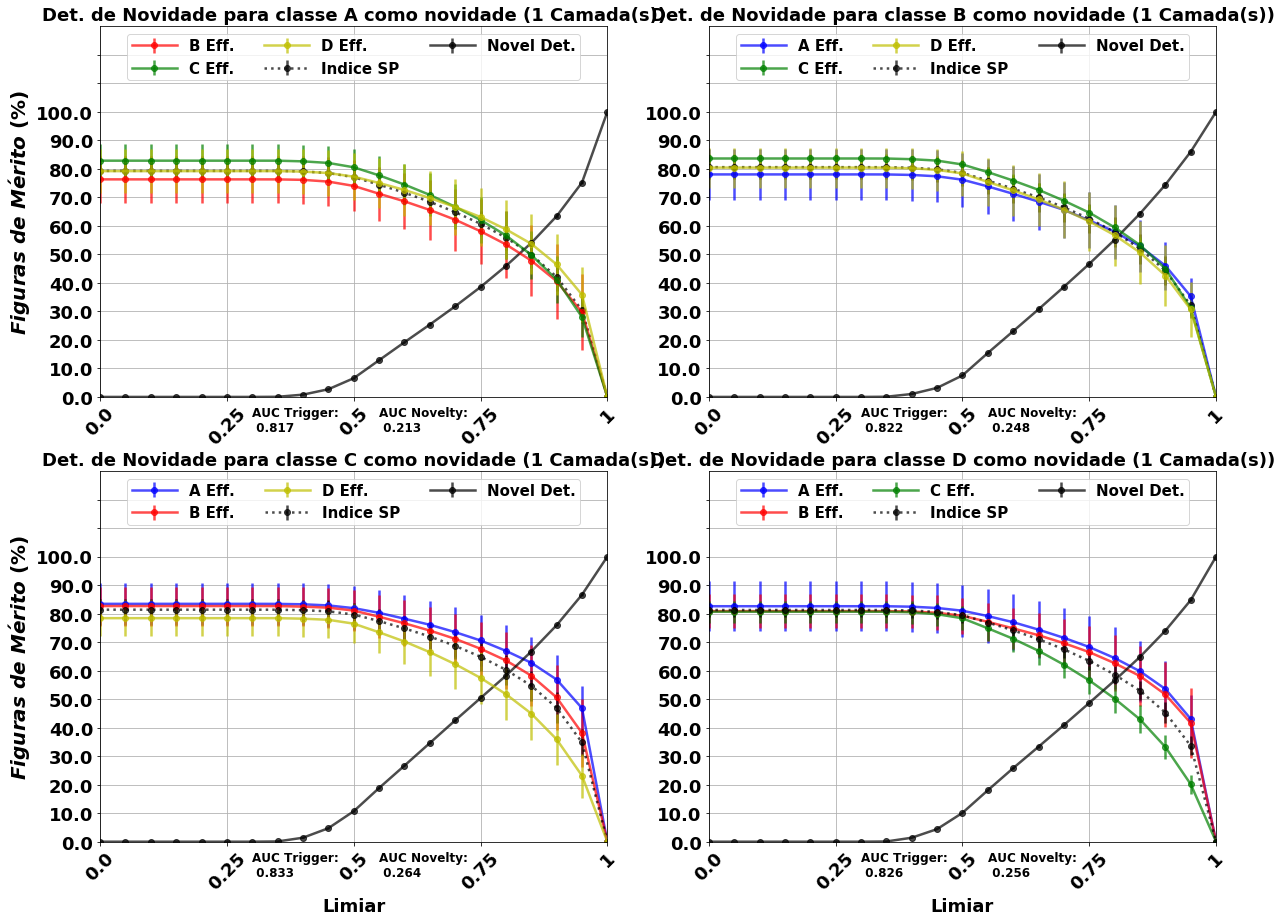

File exists


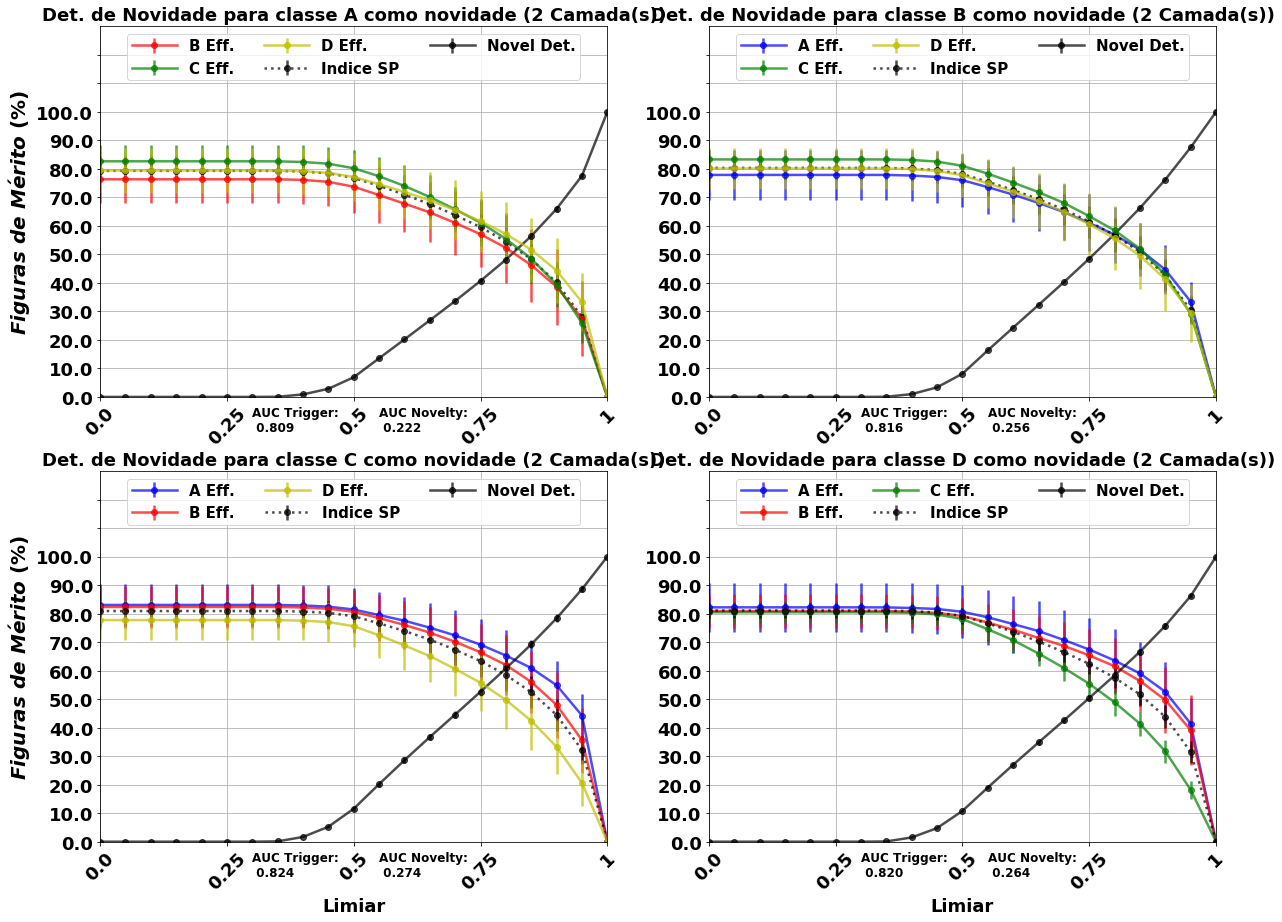

File exists


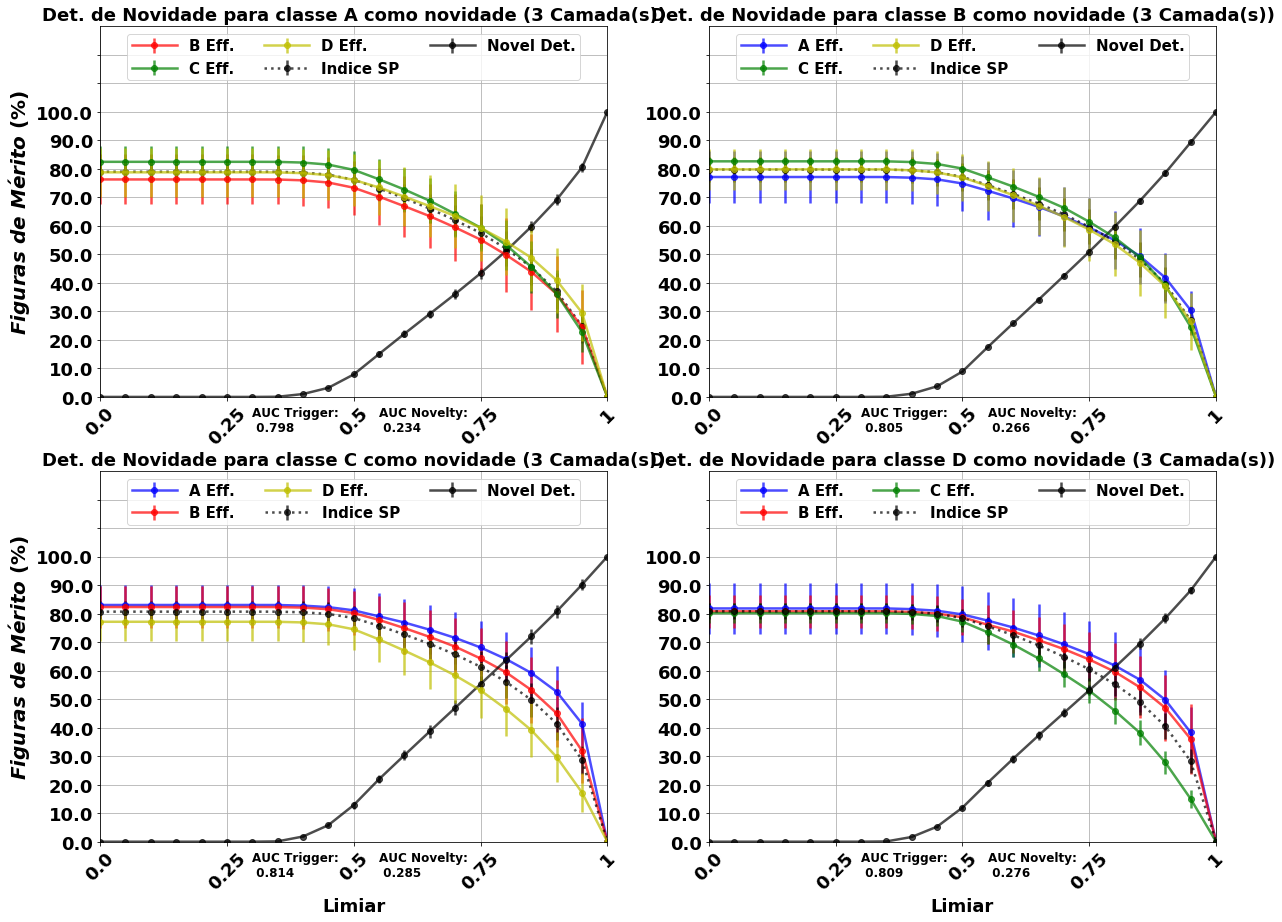

File exists


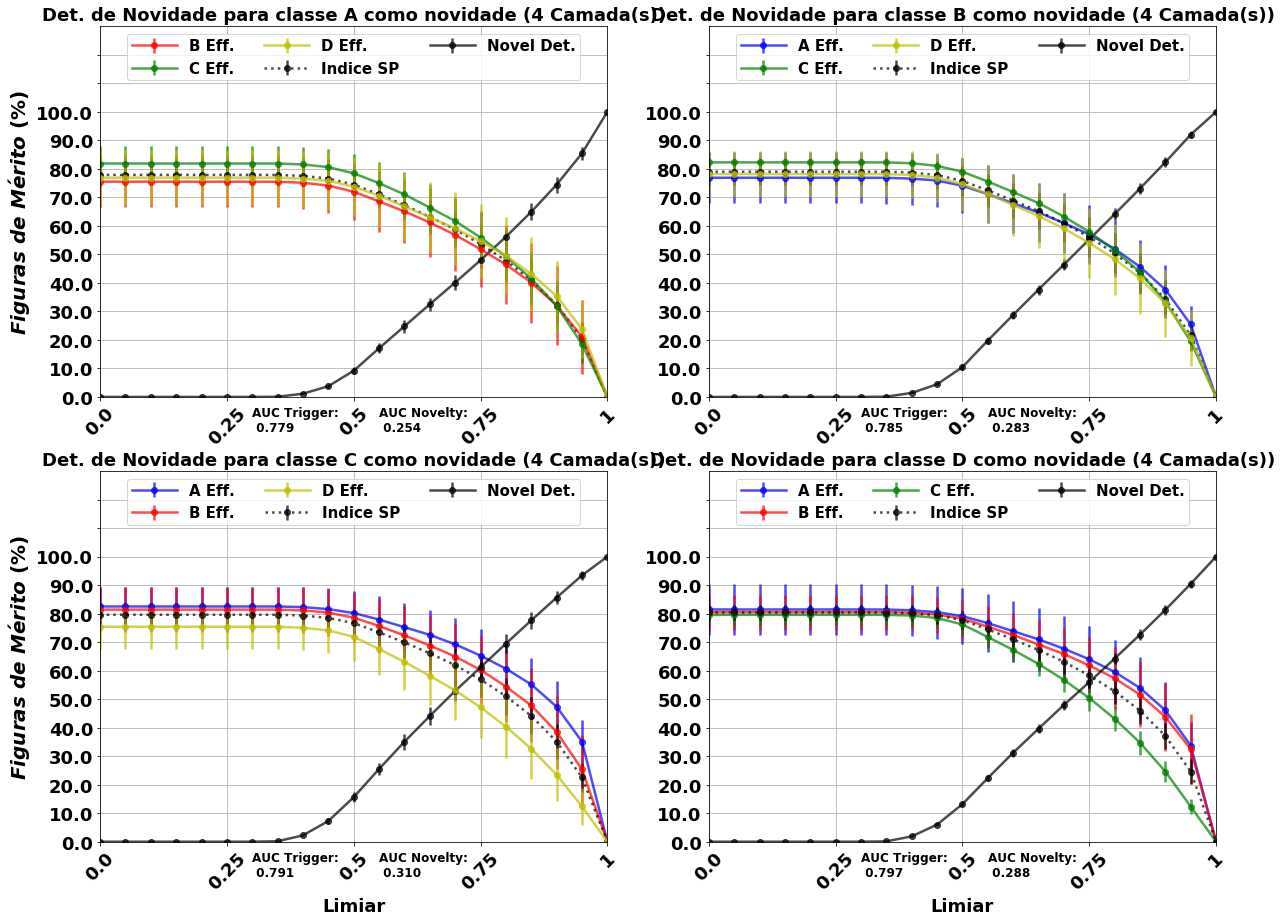

File exists


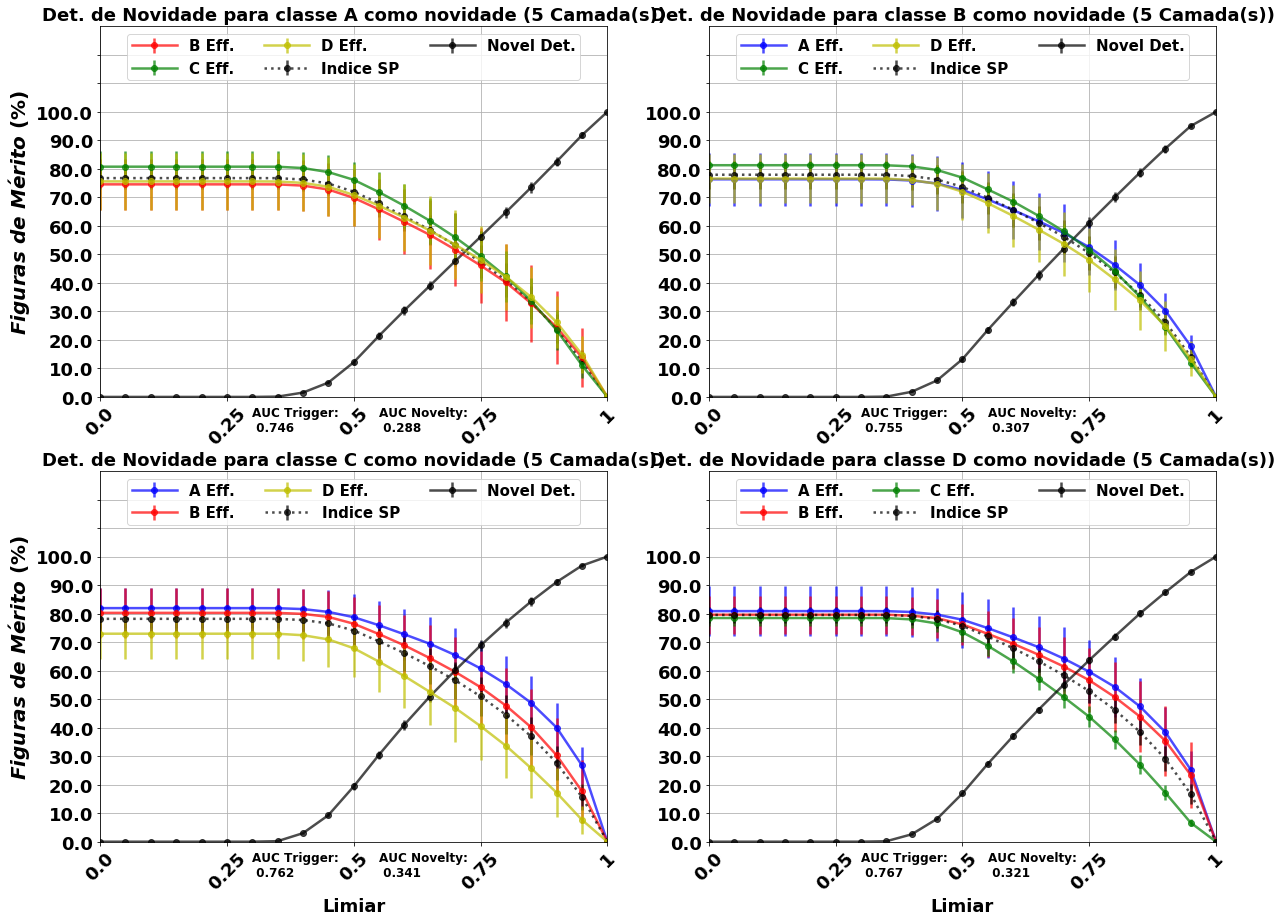

File exists


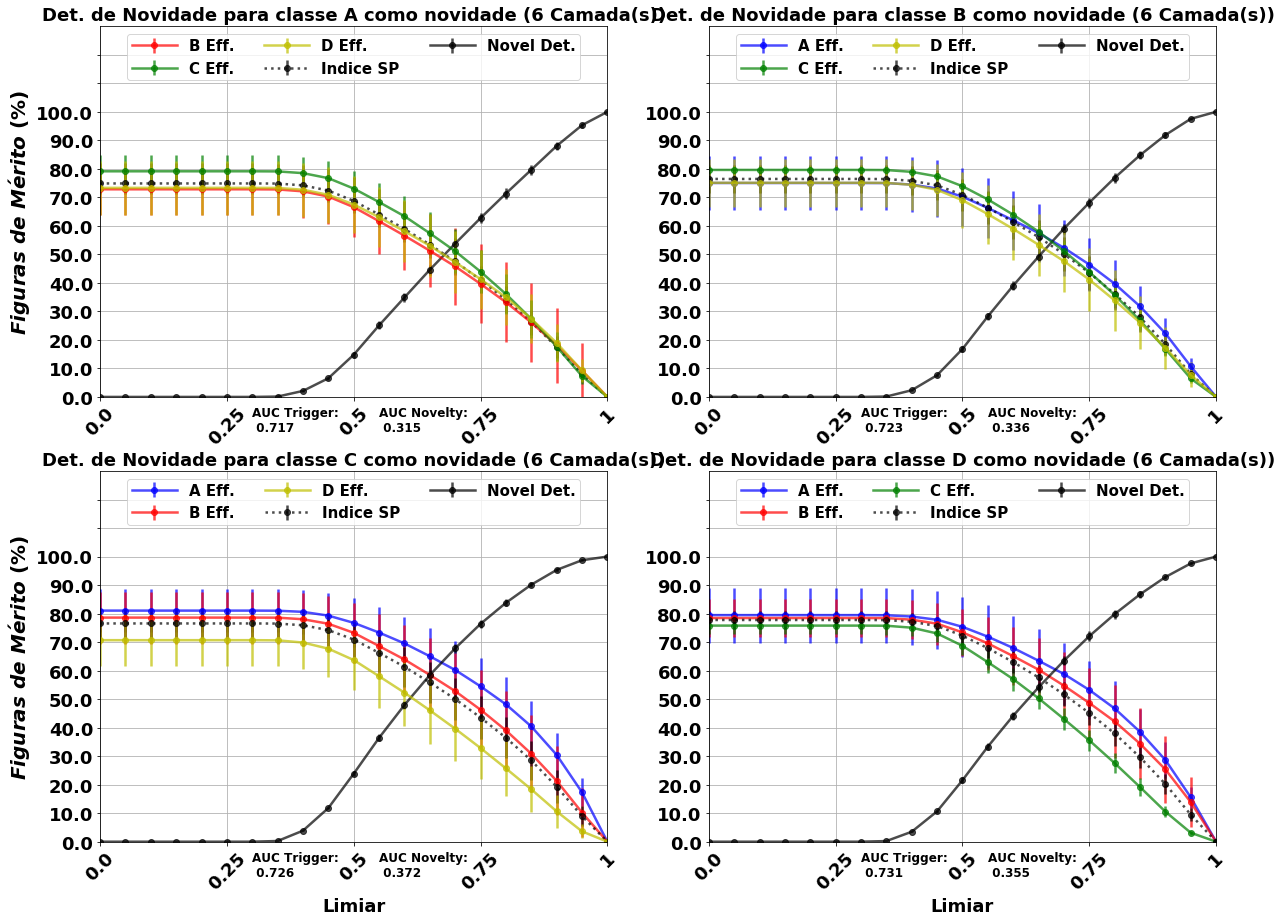

File exists


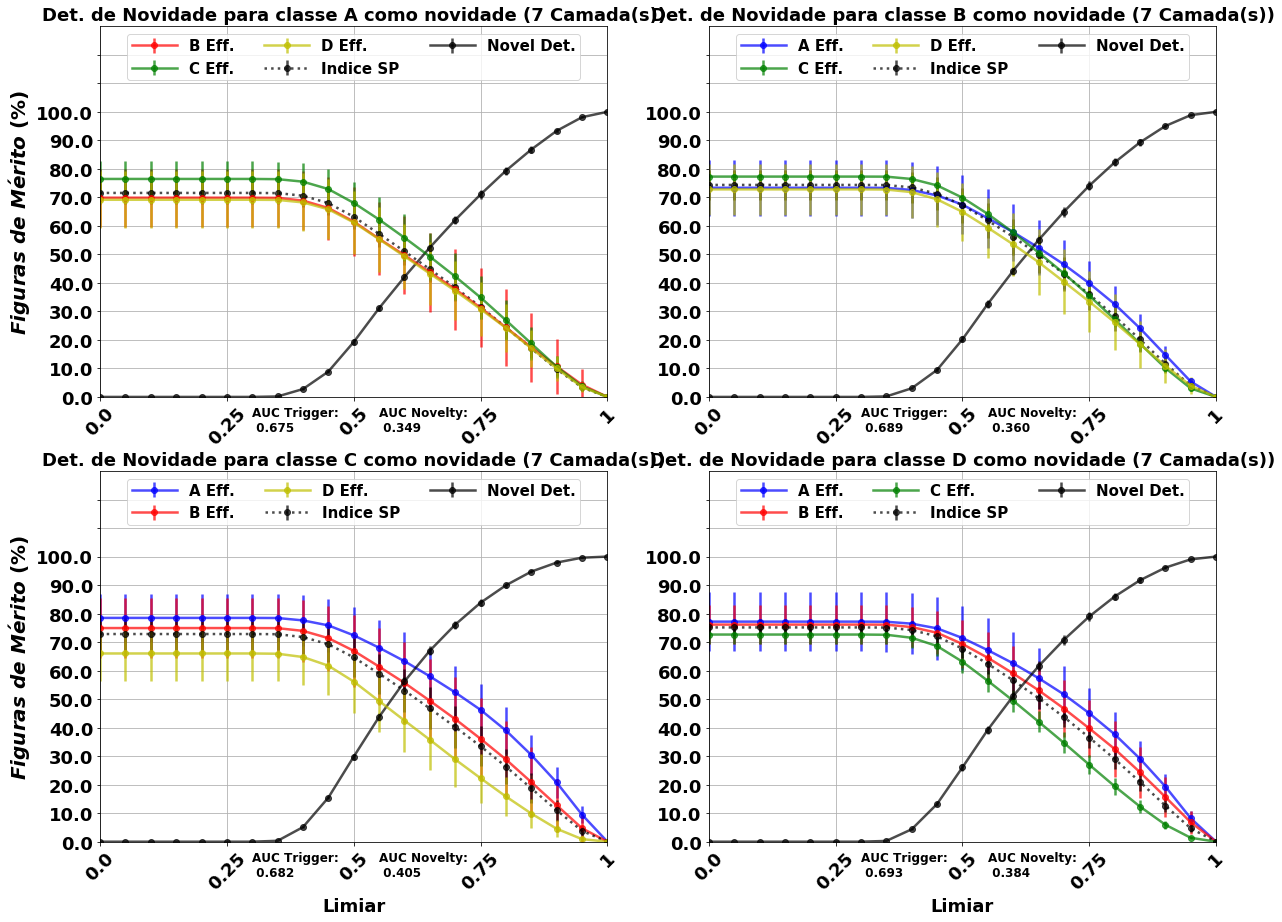

File exists


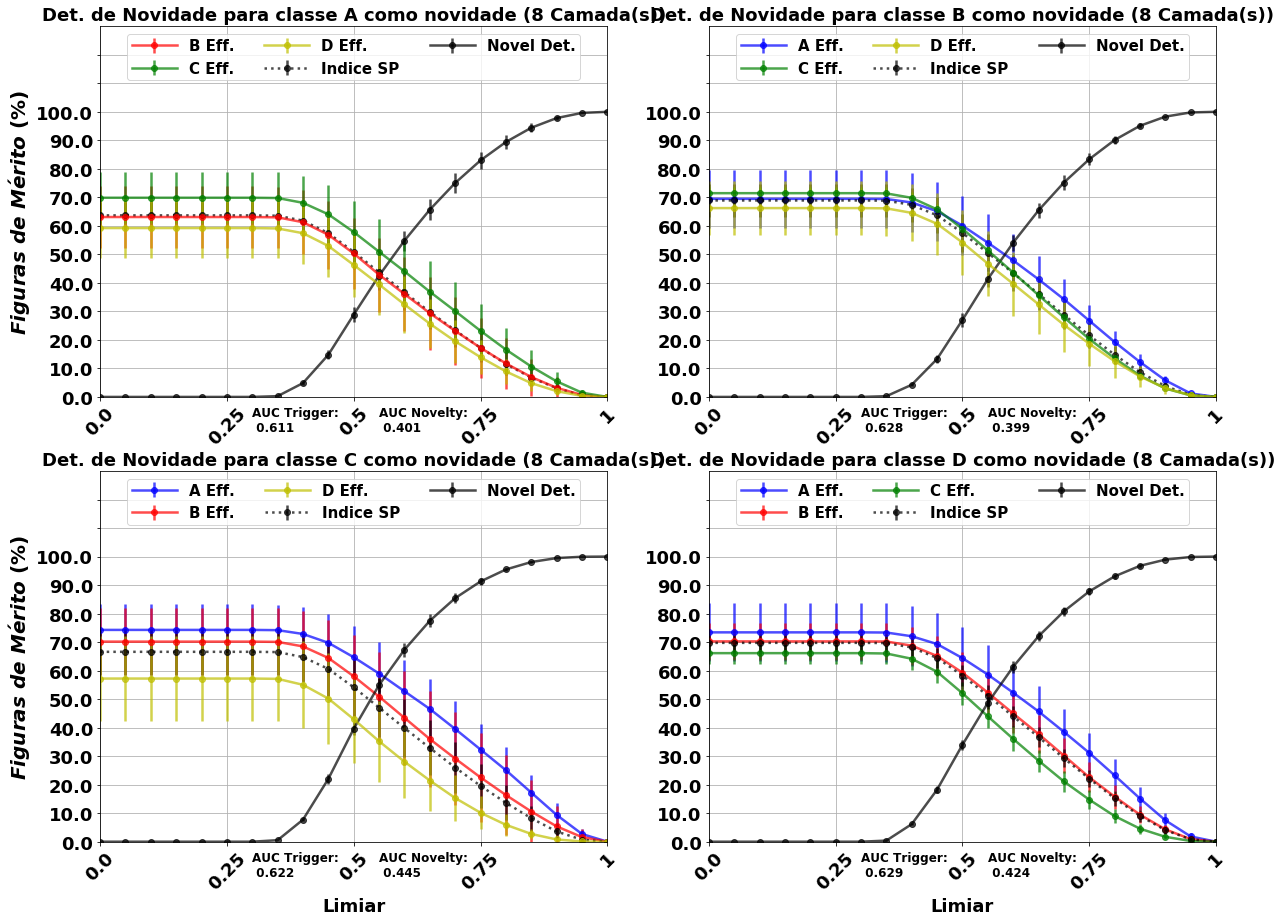

2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss
400x400x350x300x250x200x150x100x50 neurons


In [50]:
# novelty detection for SAE
# thr. sweep
layers = 8
for layer in range(1,layers+1):

    # Choose layer
    # layer = 

    # Choose neurons topology for SAE
    hidden_neurons = range(400,0,-50) + [2]
    inovelty = 0
    neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

    # generate analysis data
    save_path=results_path

    analysis_str = 'StackedAutoEncoder'
    model_prefix_str = 'RawData'
    verbose = False

    current_analysis = 'figures_of_merit'

    analysis_file_name='%s/%s/%s_novelty_detection_%s_neurons_thr_sweep.jbl'%(results_path,analysis_str,analysis_name, neurons_str)

#     if os.path.exists(analysis_file_name):
#             os.remove(analysis_file_name)

    if not os.path.exists(analysis_file_name):

        params_str = trn_params.get_params_str()

        thr_mat = np.round(np.arange(-0.0,1.05,0.05),3)
        thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

        class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        novelty_eff_mat = np.zeros([n_folds,len(thr_mat)])
        known_acc_mat = np.zeros([n_folds,len(thr_mat)])
        known_sp_mat = np.zeros([n_folds,len(thr_mat)])
        known_trig_mat = np.zeros([n_folds,len(thr_mat)])

        class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
        novelty_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
        known_acc = np.zeros([len(np.unique(all_trgt))], dtype=object)
        known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
        known_trig = np.zeros([len(np.unique(all_trgt))], dtype=object)

        def getFiguresMetrics(inovelty):
            n_folds = len(CVO[inovelty])  
            print 'Novelty class: %01.0f - topology: %s'%(inovelty, neurons_str)
            for ifold in range(n_folds):
                classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                          trgt  = trn_trgt[inovelty], 
                                                          hidden_neurons = hidden_neurons[:layer],
                                                          layer = layer,
                                                          ifold = ifold)

                train_id, test_id = CVO[inovelty][ifold]
                # normalize known classes
                if trn_params.params['norm'] == 'mapstd':
                    scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
                elif trn_params.params['norm'] == 'mapstd_rob':
                    scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
                elif trn_params.params['norm'] == 'mapminmax':
                    scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

                known_data = scaler.transform(trn_data[inovelty][test_id,:])
    #             known_data = trn_data[inovelty][test_id,:]
                known_trgt = trn_trgt[inovelty][test_id]

                novelty_data = scaler.transform(all_data[all_trgt==inovelty])
    #             novelty_data = all_data[all_trgt==inovelty]

                output = classifier.predict(known_data)
                novelty_output = classifier.predict(novelty_data)

                for ithr,thr_value in enumerate(thr_mat): 
                    buff = np.zeros([len(np.unique(all_trgt))-1])
                    for iclass, class_id in enumerate(np.unique(all_trgt)):
                        if iclass == inovelty:
                            continue
                        output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                        correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                        output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                        class_eff_mat[ifold, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                        buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, iclass, ithr]
                    novelty_eff_mat[ifold, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                    known_acc_mat[ifold, ithr] = np.mean(buff,axis=0)
                    known_sp_mat[ifold, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                                  *np.power(np.prod(buff),1./float(len(buff)))))
                    known_trig_mat[ifold, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

            return inovelty, class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat

        # Start Parallel processing
        p = multiprocessing.Pool(processes=num_processes)

        results = p.map(getFiguresMetrics, class_labels.keys())

        p.close()
        p.join()         

        for inovelty in class_labels.keys():
            if inovelty == results[inovelty][0]:
                class_eff[inovelty]   = results[inovelty][1]
                novelty_eff[inovelty] = results[inovelty][2]
                known_acc[inovelty]   = results[inovelty][3]
                known_sp[inovelty]    = results[inovelty][4]
                known_trig[inovelty]  = results[inovelty][5]

        joblib.dump([class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat],
                    analysis_file_name,compress=9)
    else:
        print 'File exists'
        [class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat] = joblib.load(analysis_file_name) 

    # plot analysis
    import matplotlib.pyplot as plt
    %matplotlib inline  

    fig = plt.subplots(figsize=(20,15))

    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['legend.numpoints'] = 1
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')

    m_colors = ['b', 'r', 'g', 'y']

    for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
        ax = plt.subplot(2,2,inovelty+1)
        for iclass, m_class in enumerate(np.unique(all_trgt)):
            if novelty_class == m_class:
                ax.errorbar(thr_mat,np.mean(novelty_eff[inovelty], axis=0),
                            np.std(novelty_eff[inovelty], axis=0),fmt='o-',
                            color='k',alpha=0.7,linewidth=2.5,
                            label='Novel Det.')
    #             ax.errorbar(thr_mat,np.mean(known_acc[inovelty], axis=0),
    #                         np.std(known_acc[inovelty], axis=0),fmt='o--',
    #                         color='k',alpha=0.7,linewidth=2.5,
    #                         label='Known Acc.')
                ax.errorbar(thr_mat,np.mean(known_sp[inovelty], axis=0),
                            np.std(known_sp[inovelty], axis=0),fmt='o:',
                            color='k',alpha=0.7,linewidth=2.5,
                            label='Indice SP')
#                 ax.errorbar(thr_mat,np.mean(known_trig[inovelty], axis=0),
#                             np.std(known_trig[inovelty], axis=0),fmt='o-.',
#                             color='k',alpha=0.7,linewidth=2.5,
#                             label='Known Trig.')
            else:
                ax.errorbar(thr_mat,np.mean(class_eff[inovelty][:, iclass, :], axis=0),
                            np.std(class_eff[inovelty][:, iclass, :], axis=0),fmt='o-',
                            color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                           label='%s Eff.'%(class_labels_txt[iclass]))
        ax.set_xticks([0.0,0.25,0.5,0.75,1])
        ax.set_xticklabels([0.0,0.25,0.5,0.75,1],rotation=45, fontsize=18)
        ax.set_title('Det. de Novidade para classe %s como novidade (%i Camada(s))'%(class_labels_txt[inovelty],layer),fontsize=18,weight='bold')
        ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])

        ax.set_ylim([0.0, 1.3])
        y_ticks = np.arange(0.0,1.3,0.1)
        ax.set_yticks(np.round(y_ticks,2))
        ax.set_yticklabels(100*np.round(y_ticks,2)[np.round(y_ticks,2)<=1.0],fontsize=18)

        import sklearn.metrics as met

        def relative_auc(x,y):
            total_area = ((np.max(x)-np.min(x))*(np.max(y)-np.min(y)))
            rel_area = met.auc(x, y)/total_area
            return rel_area

        sp_auc = relative_auc(np.array(thr_mat),np.mean(known_sp[inovelty], axis=0))
        trigger_auc = relative_auc(np.array(thr_mat),np.mean(known_trig[inovelty], axis=0))
        novelty_detection_auc = relative_auc(np.array(thr_mat),np.mean(novelty_eff[inovelty], axis=0))

    #     ax.text(0.05, -0.12, 'AUC SP:\n %1.3f'%(sp_auc), fontsize=12,
    #             bbox={'facecolor':'none','edgecolor':'none', 'alpha':0.5, 'pad':10})
        ax.text(0.3, -0.12, 'AUC Trigger:\n %1.3f'%(trigger_auc), fontsize=12,
            bbox={'facecolor':'none','edgecolor':'none', 'alpha':0.5, 'pad':10})
        ax.text(0.55, -0.12, 'AUC Novelty:\n %1.3f'%(novelty_detection_auc), fontsize=12,
            bbox={'facecolor':'none','edgecolor':'none', 'alpha':0.5, 'pad':10})
#         print "----------------"
#         print "Layer: %i"%layer
#         print "Novelty Class: %i"%inovelty
#         print "AUC Trigger: %f"%trigger_auc
#         print "AUC SP: %f"%sp_auc
#         print "AUC Novelty Det.: %f"%novelty_detection_auc
        
        ax.grid()

        if inovelty > 1:
            ax.set_xlabel('Limiar',fontsize=18,weight='bold')
        if inovelty == 0 or inovelty == 2:
            ax.set_ylabel(r'$Figuras\ de\ M\acute{e}rito \  (\%)$',fontsize=20,weight='bold')

        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, ncol=3, loc='upper center')

        #Save the figure
        file_name = pict_results_path+'/'+current_analysis+'_%s_neurons_'%(neurons_str)+trn_params.get_params_str()+'.pdf'
        plt.savefig(file_name, format='pdf', bbox_inches='tight')
    plt.show()
print trn_params.get_params_str()
print '%s neurons'%neurons_str

### Figuras de Mérito - Plot por Classe

File exists


AttributeError: Unknown property axisbg

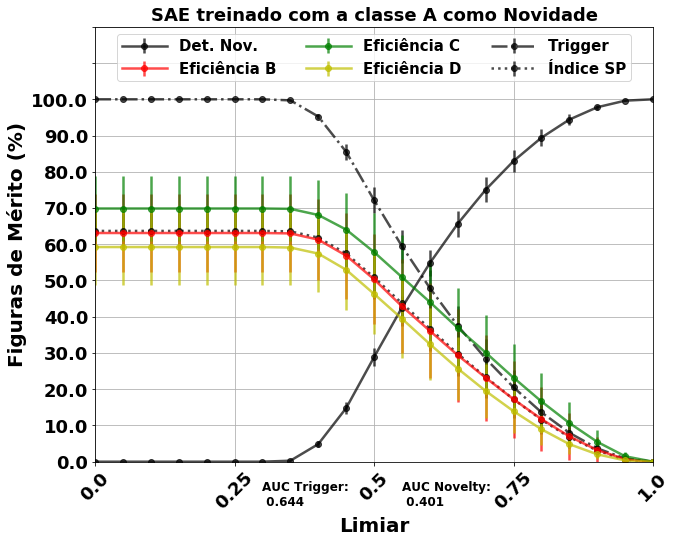

In [44]:
# novelty detection for SAE
# thr. sweep
from __future__ import unicode_literals

# Choose layer
layer = 8
inovelty = 3

# Choose neurons topology for SAE
hidden_neurons = range(400,0,-50) + [2]

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_%s_neurons_thr_sweep.jbl'%(results_path,analysis_str,analysis_name, neurons_str)

#     if os.path.exists(analysis_file_name):
#             os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()

    thr_mat = np.round(np.arange(-0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(thr_mat)])

    class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    novelty_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_acc = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_trig = np.zeros([len(np.unique(all_trgt))], dtype=object)

    def getFiguresMetrics(inovelty):
        n_folds = len(CVO[inovelty])  
        print 'Novelty class: %01.0f - topology: %s'%(inovelty, neurons_str)
        for ifold in range(n_folds):
            classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                      trgt  = trn_trgt[inovelty], 
                                                      hidden_neurons = hidden_neurons[:layer],
                                                      layer = layer,
                                                      ifold = ifold)

            train_id, test_id = CVO[inovelty][ifold]
            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

            known_data = scaler.transform(trn_data[inovelty][test_id,:])
#             known_data = trn_data[inovelty][test_id,:]
            known_trgt = trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])
#             novelty_data = all_data[all_trgt==inovelty]

            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, iclass, ithr]
                novelty_eff_mat[ifold, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

        return inovelty, class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat

    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    results = p.map(getFiguresMetrics, class_labels.keys())

    p.close()
    p.join()         

    for inovelty in class_labels.keys():
        if inovelty == results[inovelty][0]:
            class_eff[inovelty]   = results[inovelty][1]
            novelty_eff[inovelty] = results[inovelty][2]
            known_acc[inovelty]   = results[inovelty][3]
            known_sp[inovelty]    = results[inovelty][4]
            known_trig[inovelty]  = results[inovelty][5]

    joblib.dump([class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'File exists'
    [class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  


plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    fig = plt.subplots(figsize=(10,8))
    ax = plt.subplot(1,1,1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff[inovelty], axis=0),
                        np.std(novelty_eff[inovelty], axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Det. Nov.')
    #             ax.errorbar(thr_mat,np.mean(known_acc[inovelty], axis=0),
    #                         np.std(known_acc[inovelty], axis=0),fmt='o--',
    #                         color='k',alpha=0.7,linewidth=2.5,
    #                         label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp[inovelty], axis=0),
                        np.std(known_sp[inovelty], axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Índice SP')
            ax.errorbar(thr_mat,np.mean(known_trig[inovelty], axis=0),
                        np.std(known_trig[inovelty], axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Trigger')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff[inovelty][:, iclass, :], axis=0),
                        np.std(class_eff[inovelty][:, iclass, :], axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='Eficiência %s'%(class_labels_txt[iclass]))
    ax.set_xticks(np.arange(0,1.25,0.25))
    ax.set_xticklabels(np.arange(0,1.25,0.25),rotation=45, fontsize=18)
    ax.set_title('SAE treinado com a classe %s como Novidade'%class_labels_txt[inovelty],fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    import sklearn.metrics as met

    def relative_auc(x,y):
        total_area = ((np.max(x)-np.min(x))*(np.max(y)-np.min(y)))
        rel_area = met.auc(x, y)/total_area
        return rel_area

    sp_auc = relative_auc(np.array(thr_mat),np.mean(known_sp[inovelty], axis=0))
    trigger_auc = relative_auc(np.array(thr_mat),np.mean(known_trig[inovelty], axis=0))
    novelty_detection_auc = relative_auc(np.array(thr_mat),np.mean(novelty_eff[inovelty], axis=0))

#     ax.text(0.05, -0.12, 'AUC SP:\n %1.3f'%(sp_auc), fontsize=12,
#             bbox={'facecolor':'none','edgecolor':'none', 'alpha':0.5, 'pad':10})
    ax.text(0.3, -0.12, 'AUC Trigger:\n %1.3f'%(sp_auc), fontsize=12,
        bbox={'facecolor':'none','edgecolor':'none', 'alpha':0.5, 'pad':10})
    ax.text(0.55, -0.12, 'AUC Novelty:\n %1.3f'%(novelty_detection_auc), fontsize=12,
        bbox={'facecolor':'none','edgecolor':'none', 'alpha':0.5, 'pad':10})
    
    ax.set_ylim([0.0, 1.2])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(np.round(y_ticks,2))
    ax.set_yticklabels(100*np.round(y_ticks,2)[np.round(y_ticks,2)<=1.0],fontsize=18)
    
    ax.grid()
    
    ax.set_xlabel('Limiar',fontsize=20,weight='bold')
    ax.set_ylabel('Figuras de Mérito (%)',fontsize=20,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    rect = [0.1, 0.1, 0.3, 0.4]
    ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
    a = thr_mat>=0.4
    b = thr_mat<=0.8
    selected_thr = a & b
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        novelty_class = inovelty
#         if novelty_class == m_class:
            #a = 0
        ax1.errorbar(thr_mat[selected_thr],np.mean(novelty_eff[inovelty],axis=0)[selected_thr],
                    np.std(novelty_eff[inovelty],axis=0)[selected_thr],fmt='o-',
                    color='k',alpha=0.7,linewidth=2.5,
                    label='Det. Nov.')
        ax1.errorbar(thr_mat[selected_thr],np.mean(known_sp[inovelty],axis=0)[selected_thr],
                    np.std(known_sp[inovelty],axis=0)[selected_thr],fmt='o:',
                    color='k',alpha=0.7,linewidth=2.5,
                    label='Indice SP')
#         else:
#             ax1.errorbar(thr_mat[selected_thr],np.mean(class_eff[inovelty][:, iclass, :],axis=0)[selected_thr],
#                         np.std(class_eff[inovelty][:, iclass, :],axis=0)[selected_thr],fmt='o-',
#                         color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
#                        label='C%i Eff.'%(int(m_class)+1))
    ax1.set_xticks(thr_mat[selected_thr])
    ax1.set_xticklabels(thr_mat[selected_thr],rotation=45, fontsize=12)

    ax1.set_ylim([0.0, 0.9])
    y_ticks = np.arange(0.0,1.1,0.1)
    y_ticks = np.round(y_ticks,2)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(100.*ax1.get_yticks(), fontsize=12)

    ax1.grid()
    
    plt.show()
    #Save the figure
    file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()
print '%s neurons'%neurons_str

## Curva ROC

File exists


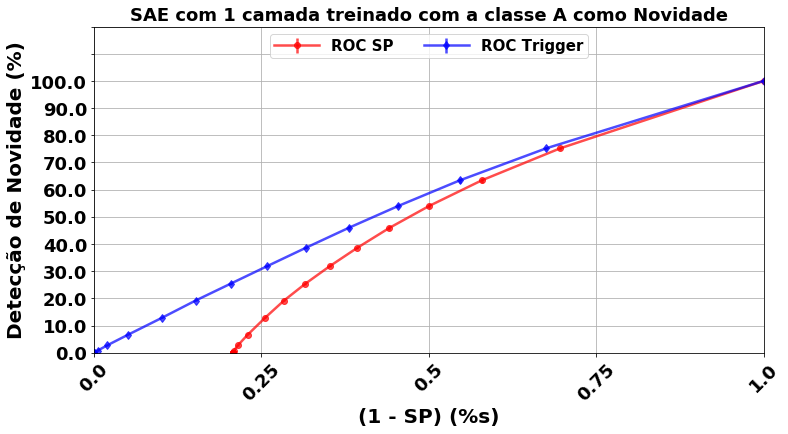

<Figure size 432x288 with 0 Axes>

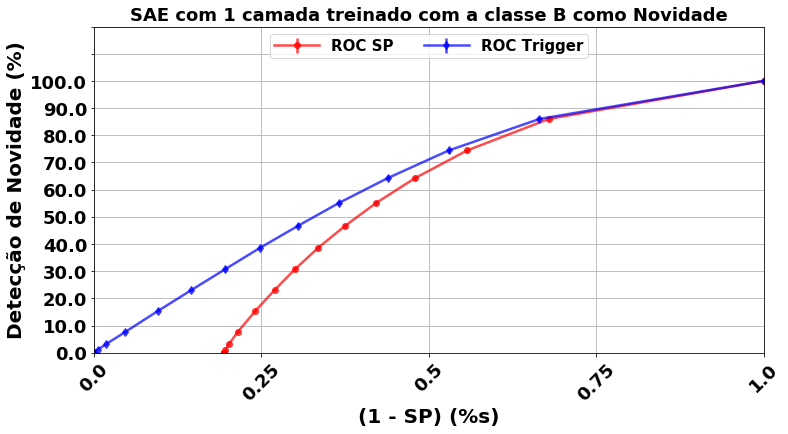

<Figure size 432x288 with 0 Axes>

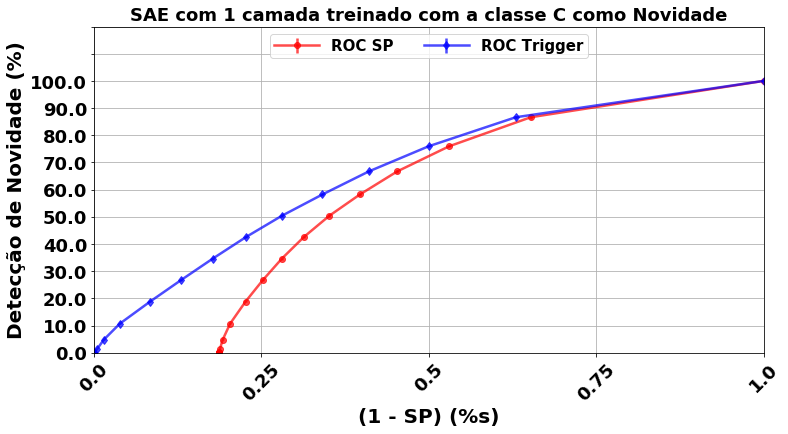

<Figure size 432x288 with 0 Axes>

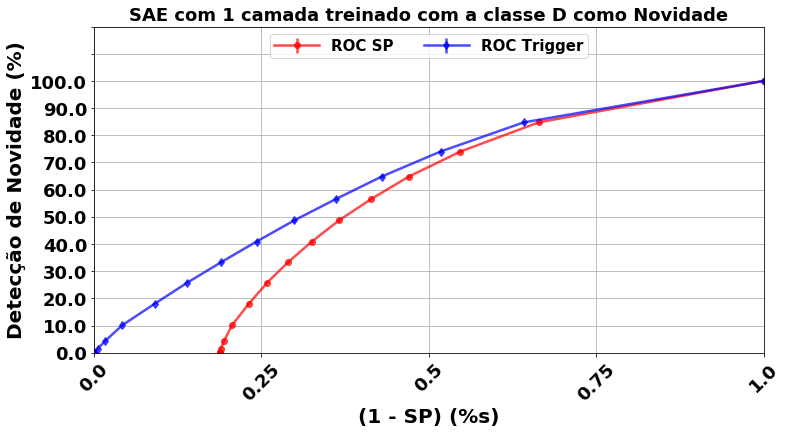

2_inits_mapstd_norm_300_epochs_256_batch_size_tanh_hidden_activation_linear_output_activation_accuracy_metric_mean_squared_error_loss
400x400 neurons


<Figure size 432x288 with 0 Axes>

In [38]:
# novelty detection for SAE
# thr. sweep
from __future__ import unicode_literals

# Choose layer
layer = 1
inovelty = 1

# Choose neurons topology for SAE
hidden_neurons = range(400,0,-50) + [2]

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_%s_neurons_thr_sweep.jbl'%(results_path,analysis_str,analysis_name, neurons_str)

#     if os.path.exists(analysis_file_name):
#             os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()

    thr_mat = np.round(np.arange(-0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(thr_mat)])

    class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    novelty_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_acc = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_trig = np.zeros([len(np.unique(all_trgt))], dtype=object)

    def getFiguresMetrics(inovelty):
        n_folds = len(CVO[inovelty])  
        print 'Novelty class: %01.0f - topology: %s'%(inovelty, neurons_str)
        for ifold in range(n_folds):
            classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                      trgt  = trn_trgt[inovelty], 
                                                      hidden_neurons = hidden_neurons[:layer],
                                                      layer = layer,
                                                      ifold = ifold)

            train_id, test_id = CVO[inovelty][ifold]
            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

            known_data = scaler.transform(trn_data[inovelty][test_id,:])
#             known_data = trn_data[inovelty][test_id,:]
            known_trgt = trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])
#             novelty_data = all_data[all_trgt==inovelty]

            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, iclass, ithr]
                novelty_eff_mat[ifold, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

        return inovelty, class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat

    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    results = p.map(getFiguresMetrics, class_labels.keys())

    p.close()
    p.join()         

    for inovelty in class_labels.keys():
        if inovelty == results[inovelty][0]:
            class_eff[inovelty]   = results[inovelty][1]
            novelty_eff[inovelty] = results[inovelty][2]
            known_acc[inovelty]   = results[inovelty][3]
            known_sp[inovelty]    = results[inovelty][4]
            known_trig[inovelty]  = results[inovelty][5]

    joblib.dump([class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'File exists'
    [class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  


plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    fig = plt.subplots(figsize=(12,6))
    ax = plt.subplot(1,1,1)
    
    xdata1 = np.ones(np.mean(known_sp[inovelty], axis=0).shape) - np.mean(known_sp[inovelty], axis=0)
    xdata2 = np.ones(np.mean(known_sp[inovelty], axis=0).shape) - np.mean(known_trig[inovelty], axis=0)
        
    ax.errorbar(xdata1, np.mean(novelty_eff[inovelty], axis=0),
                np.std(novelty_eff[inovelty], axis=0),fmt='o-',
                color='r',alpha=0.7,linewidth=2.5,
                label='ROC SP')
    ax.errorbar(xdata2, np.mean(novelty_eff[inovelty], axis=0),
                np.std(novelty_eff[inovelty], axis=0),fmt='d-',
                color='b',alpha=0.7,linewidth=2.5,
                label='ROC Trigger')
#     ax.errorbar(thr_mat,np.mean(known_acc[inovelty], axis=0),
#                 np.std(known_acc[inovelty], axis=0),fmt='o--',
#                 color='k',alpha=0.7,linewidth=2.5,
#                 label='Known Acc.')
    ax.set_xticks(np.arange(0,1.25,0.25))
    ax.set_xticklabels(np.arange(0,1.25,0.25),rotation=45, fontsize=18)
    ax.set_title('SAE com %i camada treinado com a classe %s como Novidade'%(layer,class_labels_txt[inovelty]),fontsize=18,weight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])
    
    ax.set_ylim([0.0, 1.2])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(np.round(y_ticks,2))
    ax.set_yticklabels(100*np.round(y_ticks,2)[np.round(y_ticks,2)<=1.0],fontsize=18)
    
    ax.grid()
    
    ax.set_xlabel('(1 - SP) (%s)',fontsize=20,weight='bold')
    ax.set_ylabel('Detecção de Novidade (%)',fontsize=20,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')
    
    plt.show()
    #Save the figure
    file_name = pict_results_path+'/'+"ROC_sp_novelty_det"+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
    plt.savefig(file_name)
print trn_params.get_params_str()
print '%s neurons'%neurons_str

In [ ]:
# novelty detection for SAE
# thr. sweep

# Choose layer
layer = 4
inovelty = 1

# Choose neurons topology for SAE
hidden_neurons = range(400,0,-50) + [2]

neurons_str = SAE[inovelty].getNeuronsString(all_data, hidden_neurons=hidden_neurons[:layer])

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'
verbose = False

current_analysis = 'figures_of_merit'

analysis_file_name='%s/%s/%s_novelty_detection_%s_neurons_thr_sweep.jbl'%(results_path,analysis_str,analysis_name, neurons_str)

#     if os.path.exists(analysis_file_name):
#             os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):

    params_str = trn_params.get_params_str()

    thr_mat = np.round(np.arange(-0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(thr_mat)])

    class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    novelty_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_acc = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)
    known_trig = np.zeros([len(np.unique(all_trgt))], dtype=object)

    def getFiguresMetrics(inovelty):
        n_folds = len(CVO[inovelty])  
        print 'Novelty class: %01.0f - topology: %s'%(inovelty, neurons_str)
        for ifold in range(n_folds):
            classifier = SAE[inovelty].loadClassifier(data  = trn_data[inovelty],
                                                      trgt  = trn_trgt[inovelty], 
                                                      hidden_neurons = hidden_neurons[:layer],
                                                      layer = layer,
                                                      ifold = ifold)

            train_id, test_id = CVO[inovelty][ifold]
            # normalize known classes
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(trn_data[inovelty][train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(trn_data[inovelty][train_id,:])

            known_data = scaler.transform(trn_data[inovelty][test_id,:])
#             known_data = trn_data[inovelty][test_id,:]
            known_trgt = trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])
#             novelty_data = all_data[all_trgt==inovelty]

            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, iclass, ithr]
                novelty_eff_mat[ifold, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))

        return inovelty, class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat

    # Start Parallel processing
    p = multiprocessing.Pool(processes=num_processes)

    results = p.map(getFiguresMetrics, class_labels.keys())

    p.close()
    p.join()         

    for inovelty in class_labels.keys():
        if inovelty == results[inovelty][0]:
            class_eff[inovelty]   = results[inovelty][1]
            novelty_eff[inovelty] = results[inovelty][2]
            known_acc[inovelty]   = results[inovelty][3]
            known_sp[inovelty]    = results[inovelty][4]
            known_trig[inovelty]  = results[inovelty][5]

    joblib.dump([class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat],
                analysis_file_name,compress=9)
else:
    print 'File exists'
    [class_eff, novelty_eff, known_acc, known_sp, known_trig, thr_mat] = joblib.load(analysis_file_name) 

th = 0.75
threshold = np.where(thr_mat==th)
print 'Threshold value: %f'%th
for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    print "\nNovelty Class: %i"%inovelty
    print "SP: %f +- %f"%(np.mean(known_sp[inovelty],axis=0)[threshold], np.var(known_sp[inovelty],axis=0)[threshold])
    print "Novelty Effi: %f +- %f"%(np.mean(novelty_eff[inovelty],axis=0)[threshold], np.var(novelty_eff[inovelty],axis=0)[threshold] )
    print "Known Acc.: %f"%np.mean(known_acc[inovelty],axis=0)[threshold]
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class != m_class:
            print "Effi. Class %i: %f"%(iclass, np.mean(class_eff[inovelty][:, iclass, :],axis=0)[threshold])